# CMIP6 Biogemistry
*Paul Lerner, Hilary I. Palevsky, Julius Busecke, Emma Cavan, Yassir Eddebbar, Andrea Fassbender, Mara Freilich, Jonathan Lauderdale, Jessica Luo, Precious Mongwe,  Britt Stephens, Shawnee Traylor*

This notebook contains multiple air-sea CO2 flux analyses and validation of the spatial extent of the Oxygen Minimum Zones (OMZs) in the global ocean from the [CMIP6 hackathon](https://cmip6hack.github.io/#/) participtants. These analysis are selected, edited, and ordered in such a way so as to be easy to use, understand, and be time-efficient. Comments and suggestions are much appreciated!

# Global air-sea flux over historical period

In this notebook, we examine the trends in air-sea CO$_2$ flux and the spatial distribution of that flux. The ocean plays a large role in regulating atmospheric CO$_2$ concentrations as a carbon sink ([Sabine et al 2004](https://science.sciencemag.org/content/305/5682/367), [Dong et al 2016](https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-14-00788.1)). This work uses the CMIP6 ensemble to better understand how and where the ocean takes up CO$_2$. The oceanic carbon sink has multiple components, an abiotic component (the solubility pump) due to the solubility of CO$_2$ in seawater and a biotic component (the biological pump) due to fixation of carbon by marine organisms. There is considerable spatial and temporal variability in both air-sea CO$_2$ flux and storage. Recent work has shown that the Southern Ocean has a dominant role in air-sea CO$_2$ flux ([Caldeira and Duffy 2001](https://science.sciencemag.org/content/287/5453/620), [Landschützer et al. 2014](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014GB004853)). Because of the long timescales of equilibration of ocean CO$_2$, ocean circulation can play an important role in determining the patterns of air-sea CO$_2$ flux ([Doney et al 2009](https://www.sciencedirect.com/science/article/pii/S096706450800427X)). Projecting the atmospheric CO$_2$ concentrations as well as the functioning of marine ecosystems requires an understanding of the current state and future changes in the oceanic carbon cycle. The first step is to [load all of the models](#section1) in the CMIP6 ensemble that contain a biogeochemical component. We'll clean up the data and introduce you to some useful pre-processing tools. We then compare the [global air-sea fluxes and trends across the model ensemble](#section2) and examine the [seasonality](#section3) in a few locations.

In [32]:
%matplotlib inline

import xarray as xr
import intake
import cf_units as cf
import cartopy
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
from IPython.display import display, clear_output
import sys
import os
import cmocean.cm as cmo
from dask.diagnostics import ProgressBar
from cmip6_preprocessing.parse_static_metrics import parse_metrics
from cmip6_preprocessing.preprocessing import combined_preprocessing, correct_lon, broadcast_lonlat

# Note that warnings have been turned off for readability
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

<a id='section1'></a>
## Loading data
### Search and discovery

We can see the number of entries for each category of the CMIP6 collection, including number of institution (instution_id), number of variables (variable_id), experiment labels (experiment_id), etc. 

#### Finding unique entries
Let's query the data to see what models ("source_id"), experiments ("experiment_id") and temporal frequencies ("table_id") are available.




In [ ]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id','member_id'])
pprint.pprint(uni_dict, compact=True)

#### Searching for specific datasets

Find all models with the air-sea CO2 flux (fgco2), pCO2 (spco2), and sea surface temperature (tos) at monthly frequency (Omon) from the ocean for the `historical` experiments. Note these data are currently only available in the Google cloud at monthly, not at annual frequency.



In [ ]:
models = set(uni_dict['source_id']['values']) # all the models, sorted alphabetically

for var_id in ['spco2','fgco2','tos']: # were are going to only look at first ensemble member of historical simulations
    query = dict(experiment_id='historical', table_id='Omon', 
                 variable_id=var_id, grid_label=['gn'])  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models=list(models)
models

In [4]:
# JB: There is some weird issue with the IPSL model that messes up the combined preprocessing
models = [m for m in models if 'IPSL' not in m]
# same is applied for the o2 models

In [ ]:
#Find all data for these absolute, abiotic, natural air-sea CO2 flux data, and pCO2 data and store these as catalogs 

cat_fgco2nat = col.search(experiment_id=['historical'], table_id='Omon',
                          variable_id='fgco2nat', grid_label=['gn'], source_id=models) # air-sea natural CO2 flux
cat_fgco2abio = col.search(experiment_id=['historical'], table_id='Omon',
                           variable_id='fgco2abio', grid_label=['gn'], source_id=models) # air-sea abiotic CO2 flux
cat_fgco2 = col.search(experiment_id=['historical'], table_id='Omon',
                       variable_id='fgco2', grid_label=['gn'], source_id=models) # air-sea CO2 flux

cat_spco2 = col.search(experiment_id=['historical'], table_id='Omon',
                       variable_id='spco2', grid_label=['gn'], source_id=models) # surface pCO2

cat_tos = col.search(experiment_id=['historical'], table_id='Omon',
                       variable_id='tos', grid_label=['gn'], source_id=models) # surface T

models_o2 = ['CanESM5', 'CNRM-ESM2-1', 'MIROC-ES2L', 'UKESM1-0-LL', 'NorCPM1', 'NorESM1-F', 'GFDL-CM4', 'GFDL-ESM4']
cat_o2 = col.search(variable_id=['o2'], experiment_id = ['historical', 'piControl'],
                    table_id=['Omon'], source_id = models_o2)

#Look at results for a the absolute flux
cat_fgco2.df['source_id'].unique()

We only get two distinct models if we look for an experiment with abiotic CO2 flux, with multiple CESM2 ensemble members

In [ ]:
cat_fgco2abio.df

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [ ]:
dset_dict_fgco2 = cat_fgco2.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                preprocess=combined_preprocessing)
dset_dict_fgco2abio = cat_fgco2abio.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                preprocess=combined_preprocessing)
dset_dict_fgco2nat = cat_fgco2nat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                preprocess=combined_preprocessing)
dset_dict_spco2 = cat_spco2.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                preprocess=combined_preprocessing)
dset_dict_tos = cat_tos.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                preprocess=combined_preprocessing)
dset_dict_o2 = cat_o2.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                preprocess=combined_preprocessing)

`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [ ]:
dset_dict_fgco2.keys()


Here we create a dictionary `modelnames` to use short model names for label

In [ ]:
modelnames = dict(zip(list(dset_dict_fgco2.keys()),list(cat_fgco2.df['source_id'].unique()))) # create model names dictionary
modelnames

We'll keep only the first ensemble member for brevity

In [10]:
for key in dset_dict_fgco2.keys():
    dset_dict_spco2[key]=dset_dict_spco2[key].isel({'member_id' : 0})
    dset_dict_fgco2[key]=dset_dict_fgco2[key].isel({'member_id' : 0})
    dset_dict_tos[key]=dset_dict_tos[key].isel({'member_id' : 0})
for key in dset_dict_fgco2abio.keys():
    dset_dict_fgco2nat[key]=dset_dict_fgco2nat[key].isel({'member_id' : 0})
    dset_dict_fgco2abio[key]=dset_dict_fgco2abio[key].isel({'member_id' : 0})

### Preprocessing

We already used a niftly little argument `preproceess=combined_preprocessing` (thanks to J to get all the dimensions to be consistent in name (x,y) and location time (lat/lon). However, there are a few more preprocessing steps we need

We need to include the grid cell areas for each model so that the integrated fluxes can be calcualted. This can be done by calling `parse_metrics`, another part of the CMIP6_preprocessing package. 

In [ ]:
dset_dict_fgco2 = parse_metrics(dset_dict_fgco2, col)
dset_dict_fgco2abio = parse_metrics(dset_dict_fgco2abio, col)
dset_dict_fgco2nat = parse_metrics(dset_dict_fgco2nat, col)
dset_dict_spco2 = parse_metrics(dset_dict_spco2, col)
dset_dict_tos = parse_metrics(dset_dict_tos, col)

We need to make sure the units are the same between models. We will use a converstaion dictionary, `convrt_dic`, to do this

In [12]:
# convert all to gC/m2/yr, with CO2 flux positive downward
convrt_dic={'CMIP.BCC.BCC-CSM2-MR.historical.Omon.gn':-365*24*60*60.,
             'CMIP.CCCma.CanESM5.historical.Omon.gn':1000*365.*24.*60.*60.,
             'CMIP.MIROC.MIROC-ES2L.historical.Omon.gn':1000*365*24.*60.*60.,
             'CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn':1000*365*24.*60.*60.,
             'CMIP.BCC.BCC-ESM1.historical.Omon.gn':-365*24*60*60.,
             'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn': 1000*365.*24.*60.*60.,
             'CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn': 1000*365.*24.*60.*60.,
             'CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Omon.gn': 1.,
             'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn': 1.,
             'CMIP.NCAR.CESM2.historical.Omon.gn': 1000*365.*24.*60.*60.,
             'CMIP.NCC.NorCPM1.historical.Omon.gn': 1000*365.*24.*60.*60.}

for key in dset_dict_fgco2.keys():
    dset_dict_fgco2[key] = dset_dict_fgco2[key] * convrt_dic[key]
for key in dset_dict_fgco2abio.keys():
    dset_dict_fgco2abio[key] = dset_dict_fgco2abio[key] * convrt_dic[key]

<a id='section2'></a>
## Annual means and trends

Plotting the mean flux over the historical period for each simulation shows that overall the models flux CO$_2$ into the ocean in the North Atlantic and North Pacific, particularly in boundary current regions with outgassing in the low latitudes. However, there are some regions of disagreement in the sign and magnitude of the fluxes. There is considerable variability between the models in the distribution of CO$_2$ sources and sinks in the Southern Ocean, which we will examine in [more detail below](#southern_ocean).

<Figure size 432x288 with 0 Axes>

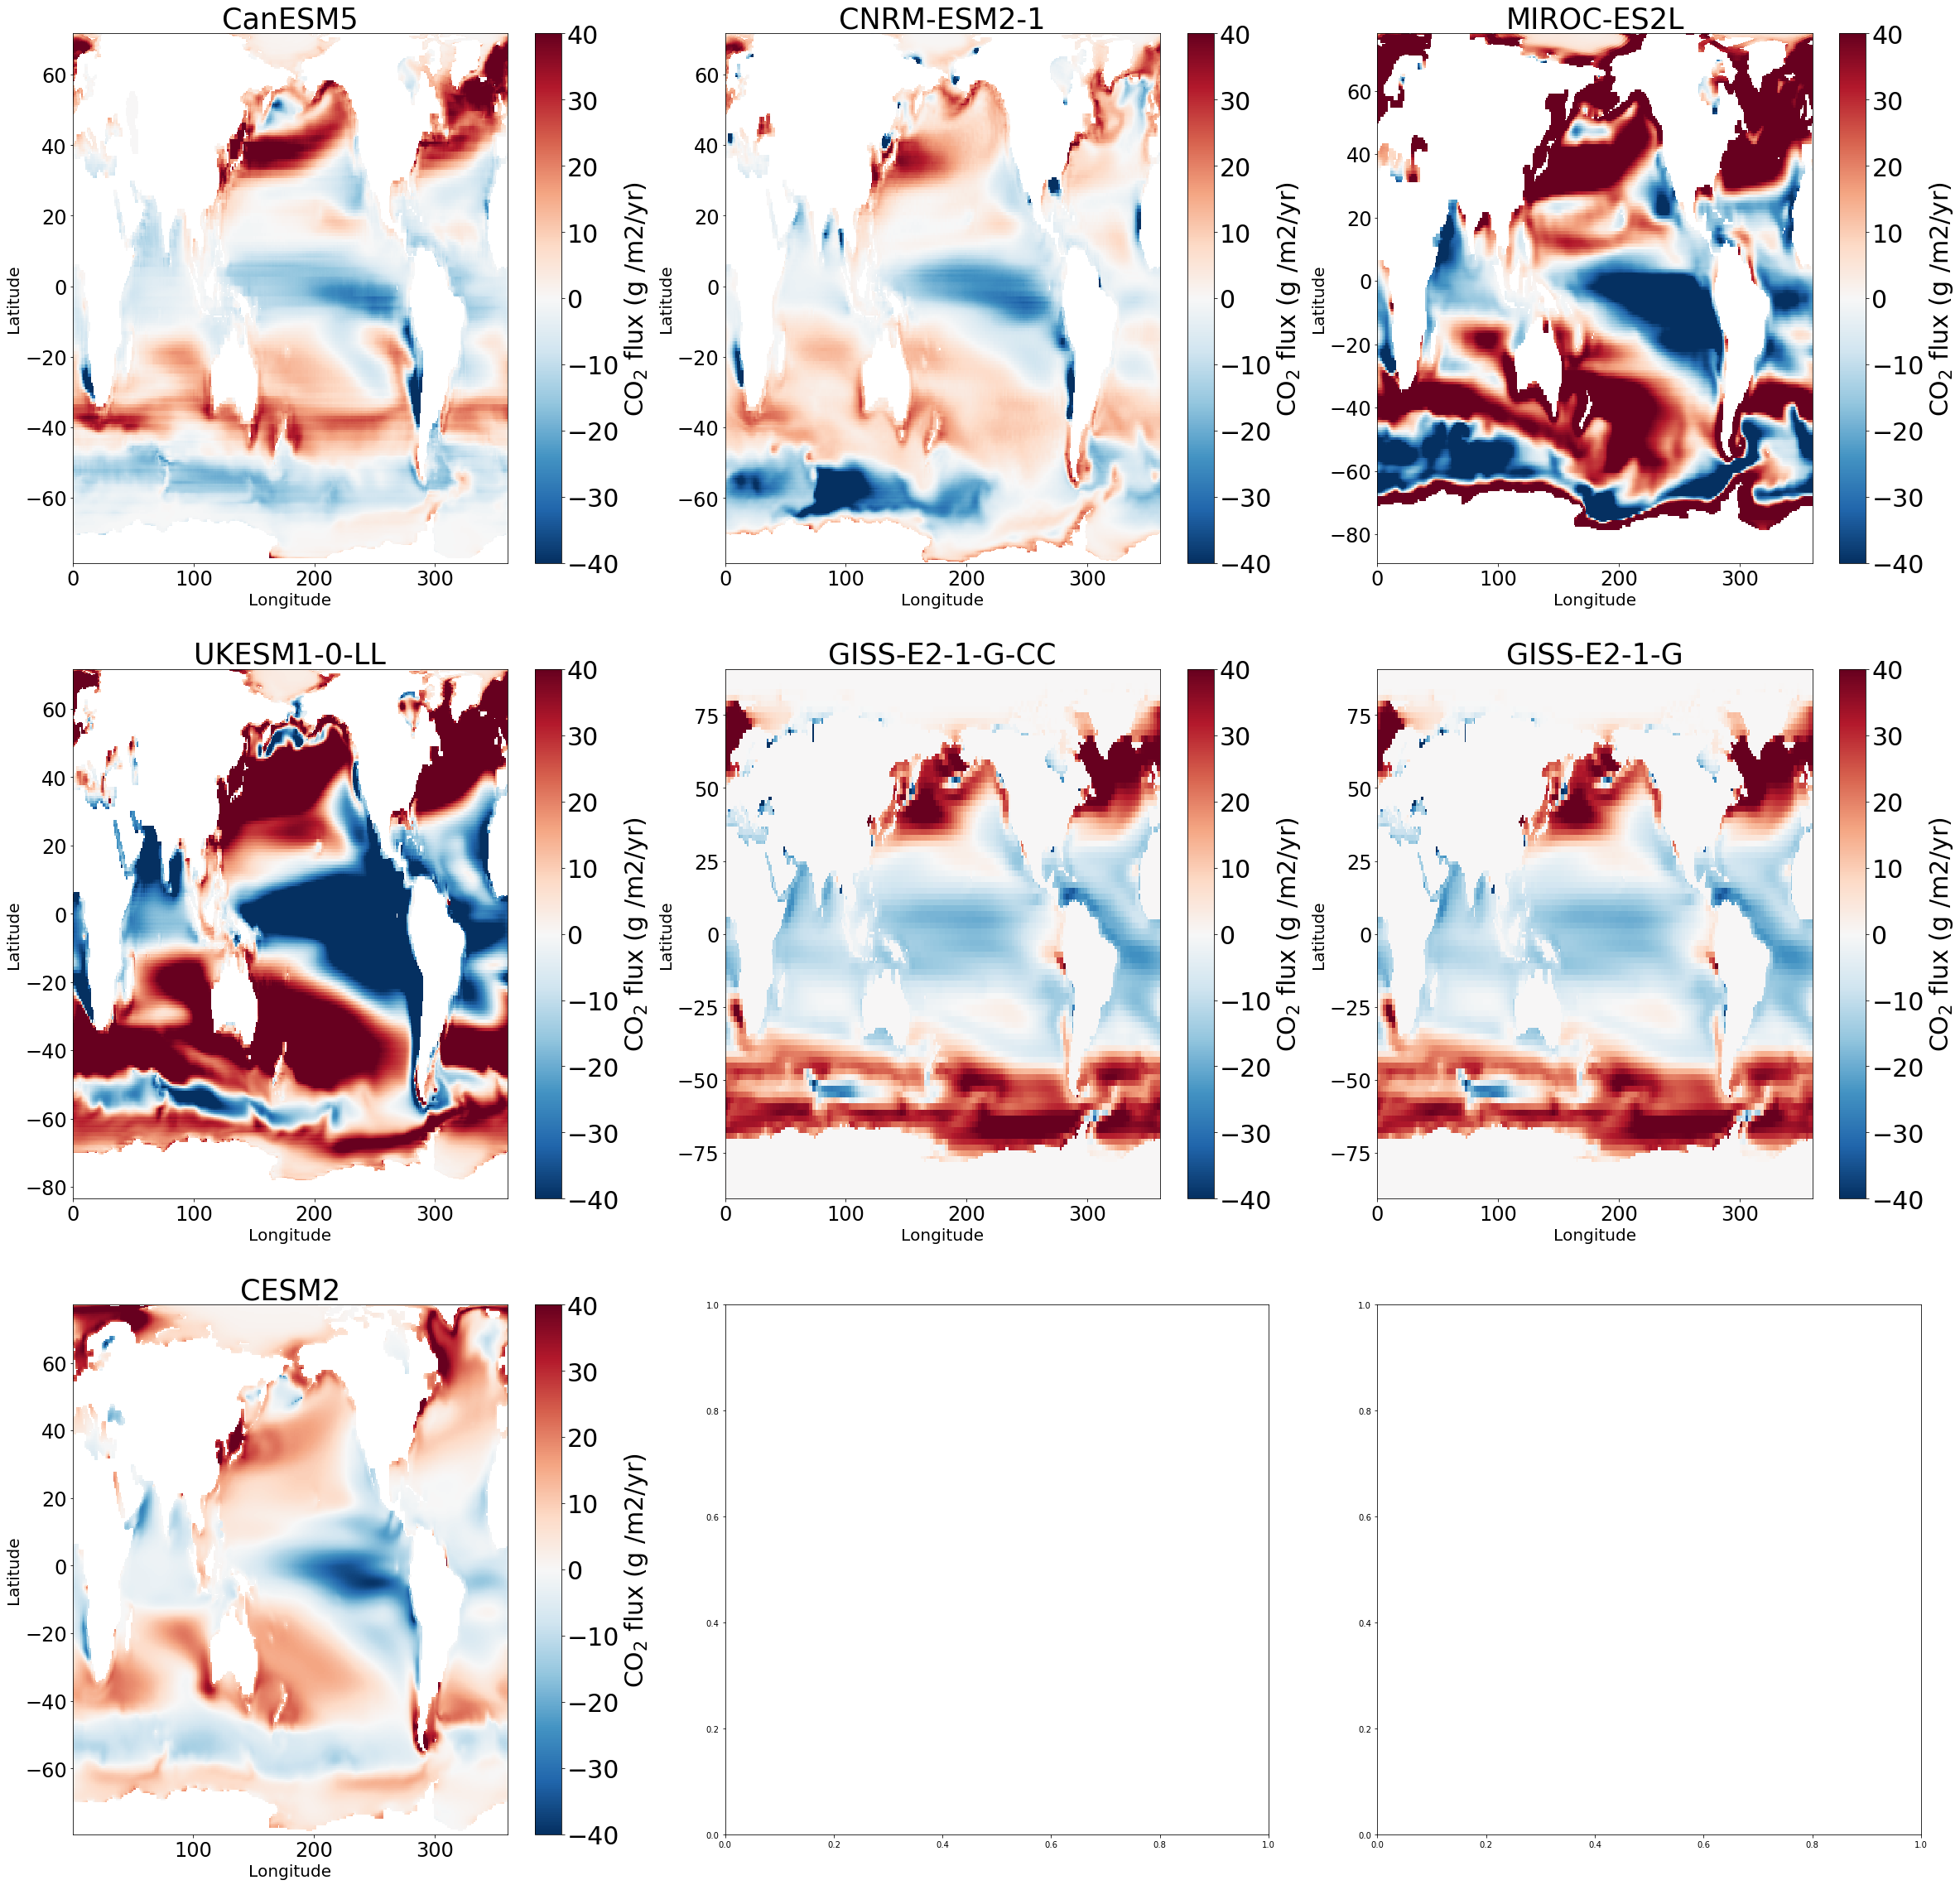

In [13]:
# plot mean heat flux for historical period


plt.figure()
fig, axes = plt.subplots(ncols=3, nrows=3,figsize=(40, 40))
cnt=0


for key in dset_dict_fgco2.keys():
    mean_plot = dset_dict_fgco2[key].fgco2.mean(dim='time')
    axs=axes[np.floor_divide(cnt,3),np.mod(cnt,3)]
    im=mean_plot.plot(ax=axs,robust=True, cmap='RdBu_r',add_colorbar = False, vmin=-40, vmax=40)
    
    # set a colorbar for each subplot
    cbar = fig.colorbar(im,ax=axs)
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('CO$_2$ flux '+'(g /m2/yr)',fontsize=30)
    
    # title is just model name
    axs.set_title(modelnames[key],fontsize=35)
    axs.set_xlabel('Longitude',fontsize=20)
    axs.set_ylabel('Latitude',fontsize=20)
    axs.tick_params(axis = 'both', which = 'major', labelsize = 24)
    axs.tick_params(axis = 'both', which = 'minor', labelsize = 16)
    cnt=cnt+1
fig.savefig('meanCO2flux.png')

Now let's look at the evolution of the global CO2 flux. We do this by taking the difference between 10 yr averages at beginning and end of historical simulation

<Figure size 432x288 with 0 Axes>

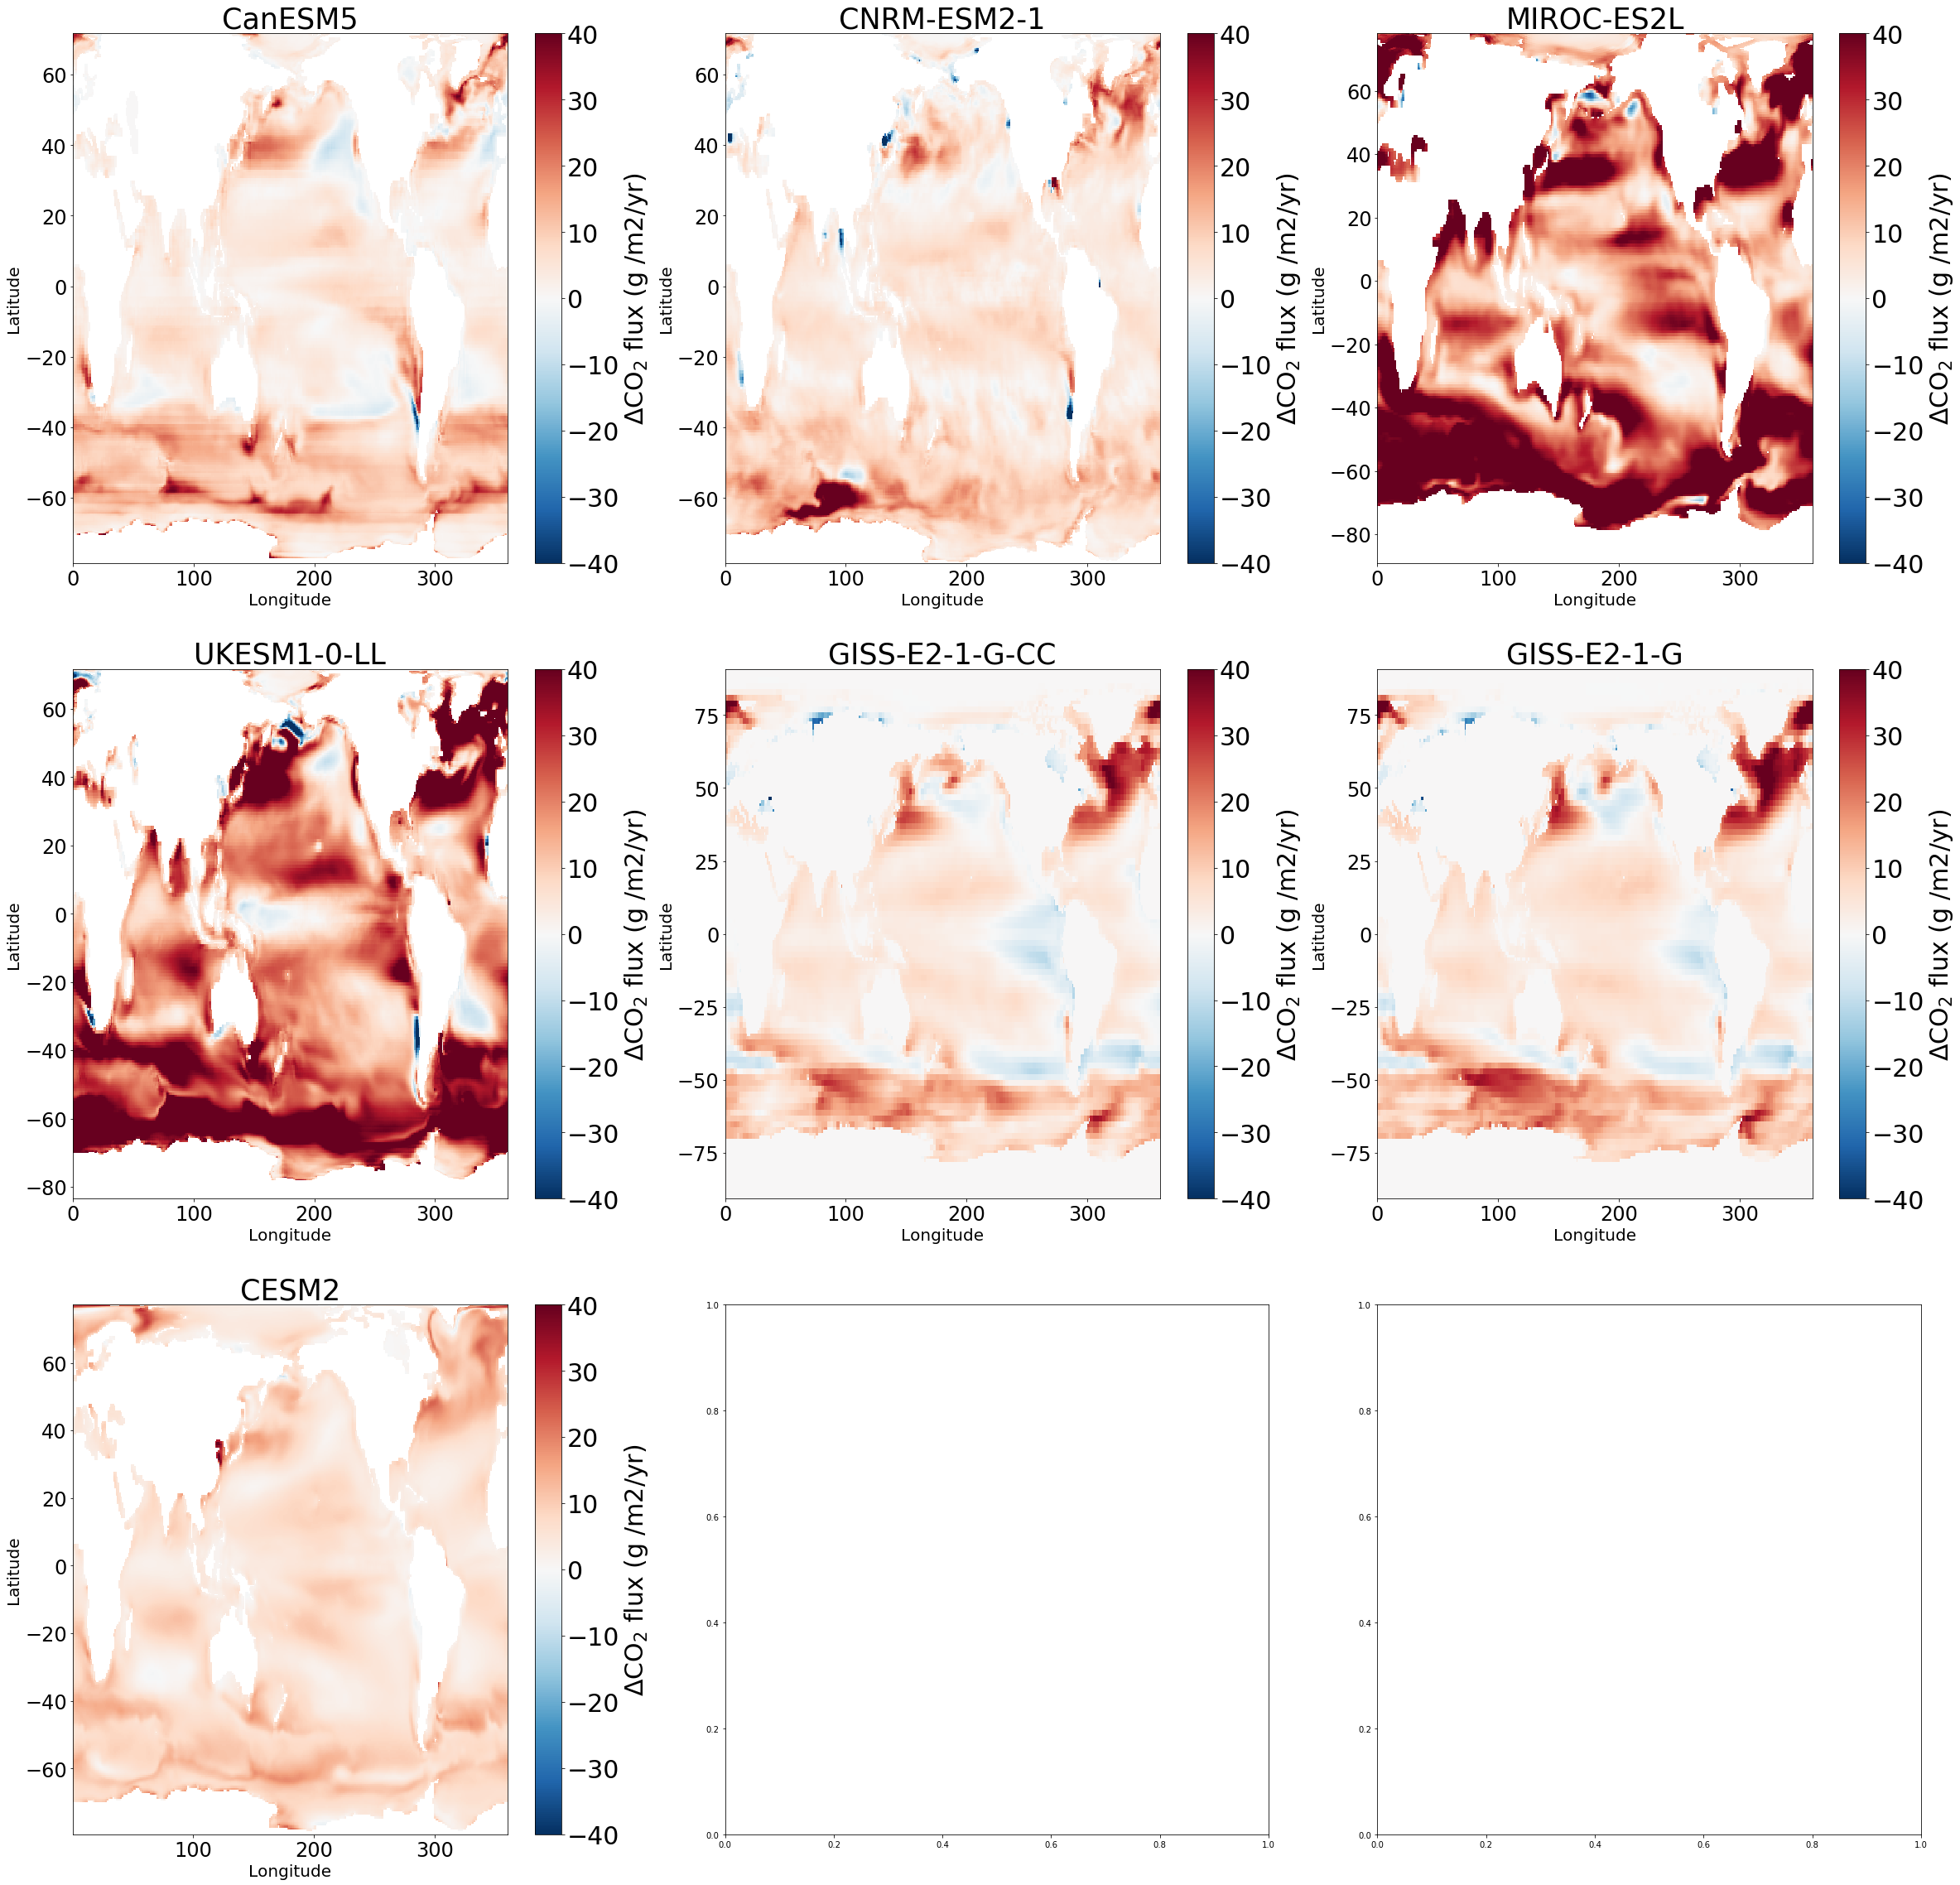

In [14]:
plt.figure()
fig, axes = plt.subplots(ncols=3, nrows=3,figsize=(40, 40))
cnt=0

for key in dset_dict_fgco2.keys():
    dset_fgco2_hbegin = dset_dict_fgco2[key].fgco2.isel(time=slice(0,10*12))
    dset_fgco2_hend = dset_dict_fgco2[key].fgco2.isel(time=slice(-10*12,-1))
    dset_fgco2_hend = dset_fgco2_hend.groupby('time.month').mean('time')
    dset_fgco2_hbegin = dset_fgco2_hbegin.groupby('time.month').mean('time')
    dset_fgco2_diff = dset_fgco2_hend - dset_fgco2_hbegin
    mean_plot = dset_fgco2_diff.mean(dim='month')
    axs=axes[np.floor_divide(cnt,3),np.mod(cnt,3)]
    im=mean_plot.plot(ax=axs,robust=True, cmap='RdBu_r',add_colorbar = False, vmin=-40, vmax=40)
    
    # set a colorbar for each subplot
    cbar = fig.colorbar(im,ax=axs)
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('$\Delta$CO$_2$ flux '+'(g /m2/yr)',fontsize=30)
    
    # title is just model name
    axs.set_title(modelnames[key],fontsize=35)
    axs.set_xlabel('Longitude',fontsize=20)
    axs.set_ylabel('Latitude',fontsize=20)
    axs.tick_params(axis = 'both', which = 'major', labelsize = 24)
    axs.tick_params(axis = 'both', which = 'minor', labelsize = 16)
    cnt=cnt+1
fig.savefig('CO2flux_diff.png')    

As expected, the ocean is becoming a stronger sink in all models, although there are clear 
differences in the magnitude of the change of the sink between models in certain regions (e.g., subpolar North Atlantic
shows a larger increase in GISS E2.1 and BCC_ESM1 than in the other models)                                                 

<a id='section3'></a>
## Seaonality of CO2 flux

In order to understand the trends in air-sea CO$_2$ fluxes, we examine the seasonality of the two components of air-sea CO$_2$ fluxes, the biotic and abiotic components. 

Since we made the choice earlier to only use one ensemble member of the abiotic CO$_2$ flux, let's extract the corresponding model flux of absolute CO$_2$

In [15]:
dset_hist_all = dict()

for key in dset_dict_fgco2abio.keys():
    dset_hist_all[key] = xr.merge([dset_dict_fgco2[key], dset_dict_fgco2abio[key]])
    dset_hist_all[key]['fgco2bio'] = dset_hist_all[key].fgco2 - dset_hist_all[key].fgco2abio


By plotting time series at indiviudal locations that correspond to long-term monitoring stations we set the stage for data/model intercomparisons

HOTS = Hawaian Ocean Time Series

OSP = Ocean Station Papa (North Pacific)

KEO = KEO time series (western subtropical North Pacific)
BATS = Bermuda Atlantic Time Series

In [16]:
# Get indices for time series sites of choice - note that output is lat lon but input is ordered lon lat
HOT = [360 - 158, 22.75]
OSP = [360 - 150, 50]
KEO = [144.6, 32.4]
BATS = [360-64.2, 31.7]

Functions to compute and plot historical climatology at fixed time series points at beginning and end of historical period. This function can be used to easily plot different models using the keys defined in the section [loading data](#section1)

In [ ]:
# for this and the next series of plots, we choose one model for ease of visualization
model = 'CMIP.NCAR.CESM2.historical.Omon.gn'

def histdec(model):
    """returns the 1st and laste decade of historical (or other) simulation
    """
    
    # absolute flux
    dset_fgco2_hbegin = dset_hist_all[model].fgco2.isel(time=slice(0,10*12))
    dset_fgco2_hend = dset_hist_all[model].fgco2.isel(time=slice(-10*12,-1))
    dset_fgco2_hend = dset_fgco2_hend.groupby('time.month').mean('time')
    dset_fgco2_hbegin = dset_fgco2_hbegin.groupby('time.month').mean('time')
    # abiotic flux
    dset_fgco2abio_hbegin = dset_hist_all[model].fgco2abio.isel(time=slice(0,10*12))
    dset_fgco2abio_hend = dset_hist_all[model].fgco2abio.isel(time=slice(-10*12,-1))
    dset_fgco2abio_hend = dset_fgco2abio_hend.groupby('time.month').mean('time')
    dset_fgco2abio_hbegin = dset_fgco2abio_hbegin.groupby('time.month').mean('time')
    # biotic flux
    dset_fgco2bio_hbegin = dset_hist_all[model].fgco2bio.isel(time=slice(0,10*12))
    dset_fgco2bio_hend = dset_hist_all[model].fgco2bio.isel(time=slice(-10*12,-1))
    dset_fgco2bio_hend = dset_fgco2bio_hend.groupby('time.month').mean('time')
    dset_fgco2bio_hbegin = dset_fgco2bio_hbegin.groupby('time.month').mean('time')
    
    return dset_fgco2_hbegin,dset_fgco2_hend,dset_fgco2abio_hbegin,dset_fgco2abio_hend,dset_fgco2bio_hbegin,dset_fgco2bio_hend


dset_fgco2_hbegin,dset_fgco2_hend,dset_fgco2abio_hbegin,dset_fgco2abio_hend,dset_fgco2bio_hbegin,dset_fgco2bio_hend = histdec(model)
dset_fgco2_hend.mean().compute()

In [18]:
def histClimPlot(key,timeSeriesLoc, timeSeriesName):
        
    # plots at beginning of historical period
    
    plt.plot(dset_fgco2_hbegin.sel(x=timeSeriesLoc[0],
                                        y=timeSeriesLoc[1],method='nearest'),
             'k',
             label='absolute flux 1st decade')
    plt.plot(dset_fgco2abio_hbegin.sel(x=timeSeriesLoc[0],
                                            y=timeSeriesLoc[1],method='nearest'),
             'b',
             label='abiotic flux 1st decade')
    plt.plot(dset_fgco2bio_hbegin.sel(x=timeSeriesLoc[0],
                                           y=timeSeriesLoc[1],method='nearest'),
             'g',
             label='biotic flux 1st decade')
    
    # plots at end of historical period
    plt.plot(dset_fgco2_hend.sel(x=timeSeriesLoc[0],
                                        y=timeSeriesLoc[1],method='nearest'),
             '--k',
             label='absolute flux last decade')
    plt.plot(dset_fgco2abio_hend.sel(x=timeSeriesLoc[0],
                                            y=timeSeriesLoc[1],method='nearest'),
             '--b',
             label='abiotic flux last decade')
    plt.plot(dset_fgco2bio_hend.sel(x=timeSeriesLoc[0],
                                           y=timeSeriesLoc[1],method='nearest'),
             '--g',
             label='biotic flux last decade')
    plt.legend()
    plt.title(timeSeriesName + ' historical climatology')
    plt.ylabel('Air-sea CO2 flux, g C/m$^2$/yr')
    plt.xlabel('Month')

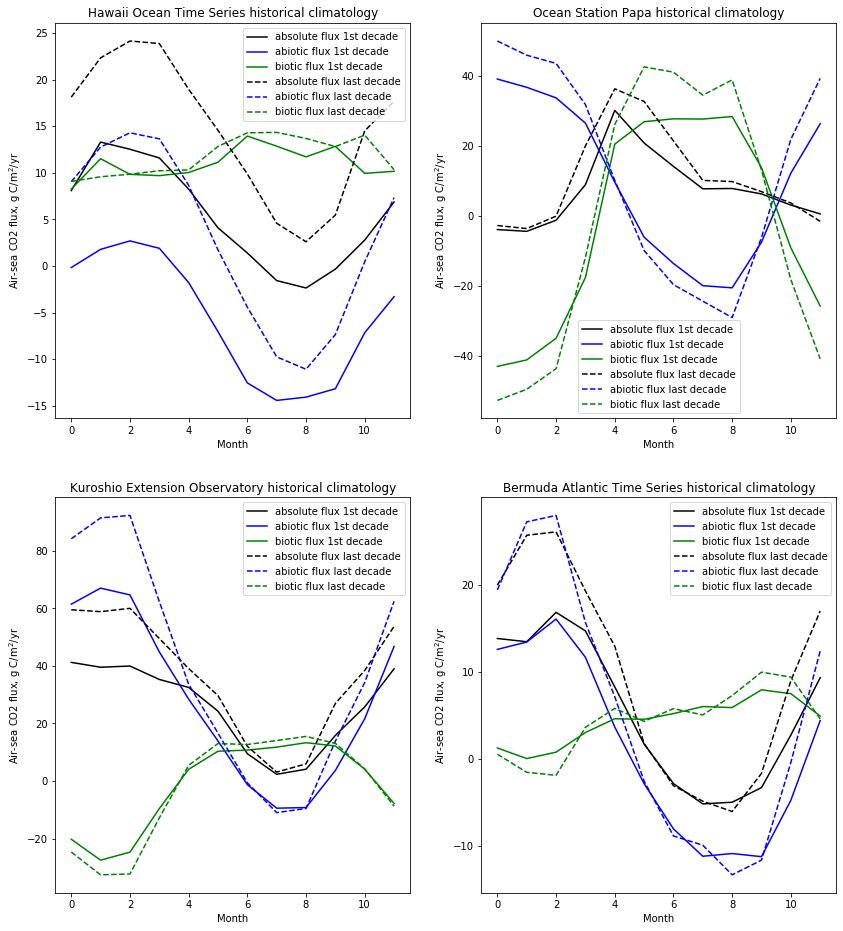

In [19]:
#Plot decadal climatology (beginning and end of historical period) at fixed time series points

fig = plt.figure(figsize=(14, 16))

ax1 = fig.add_subplot(2, 2, 1)
histClimPlot(model, HOT, 'Hawaii Ocean Time Series')

ax2 = fig.add_subplot(2, 2, 2)
histClimPlot(model, OSP, 'Ocean Station Papa')

ax3 = fig.add_subplot(2, 2, 3)
histClimPlot(model, KEO, 'Kuroshio Extension Observatory')

ax4 = fig.add_subplot(2, 2, 4)
histClimPlot(model, BATS, 'Bermuda Atlantic Time Series')



These plots reveal that changes in the biotic and abiotic sinks have led to the overall observed changes in air-sea CO$_2$ flux. For example, an increase in the biotic flux is the dominant change over the historical period in the summer at Ocean Station Papa while an increase in the abiotic flux is the dominant change at the same location in the wintertime. At HOTS, the increase in the abiotic flux is a much larger change than any change in the biotic flux over the whole annual cycle. In order to examine the global trends in each of these flux terms, we make difference maps between the beginning and end of the historical period for the different flux fields, and for Jan and Jul. Again, we do this using functions so that we can easily make these plots using other models

In [20]:
# Functions to plot difference maps between historical and end of SSP585

#General function for plotting a simple contour map of input data
def mapPlot(dataToPlot, plotTitle, levels):
    dataToPlot.plot(levels=levels)
    plt.title(plotTitle,fontsize=15)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')

#Specific function to enable plotting of a given month's CO2 flux components in the historical period, 2090s, and their difference
def mapPlotCO2ChangeByMonth(month_sel, monthName, levels):
    ax1 = fig.add_subplot(3, 3, 1)
    dataToPlot = dset_fgco2_hbegin.sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' 1st decade air-sea co2 flux', levels)
    
    ax2 = fig.add_subplot(3, 3, 2)
    dataToPlot = dset_fgco2abio_hbegin.sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' 1st decade abiotic air-sea co2 flux', levels)
    
    ax3 = fig.add_subplot(3, 3, 3)
    dataToPlot = dset_fgco2bio_hbegin.sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' 1st decade biotic air-sea co2 flux', levels)
    
    ax4 = fig.add_subplot(3, 3, 4)
    dataToPlot = dset_fgco2_hend.sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' last decade air-sea co2 flux', levels)
    
    ax5 = fig.add_subplot(3, 3, 5)
    dataToPlot = dset_fgco2abio_hend.sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' last decade abiotic air-sea co2 flux', levels)
    
    ax6 = fig.add_subplot(3, 3, 6)
    dataToPlot = dset_fgco2bio_hend.sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' last decade biotic air-sea co2 flux', levels)
    
    ax7 = fig.add_subplot(3, 3, 7)
    dataToPlot = dset_fgco2_hend.sel(month = month_sel) - dset_fgco2_hbegin.sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' change from start to end hist air-sea co2 flux', levels)
    
    ax8 = fig.add_subplot(3, 3, 8)
    dataToPlot = dset_fgco2abio_hend.sel(month = month_sel) - dset_fgco2abio_hbegin.sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' change from start to end hist abiotic air-sea co2 flux', levels)
    
    ax9 = fig.add_subplot(3, 3, 9)
    dataToPlot = dset_fgco2bio_hend.sel(month = month_sel) - dset_fgco2bio_hbegin.sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' change from start to end hist biotic air-sea co2 flux', levels)

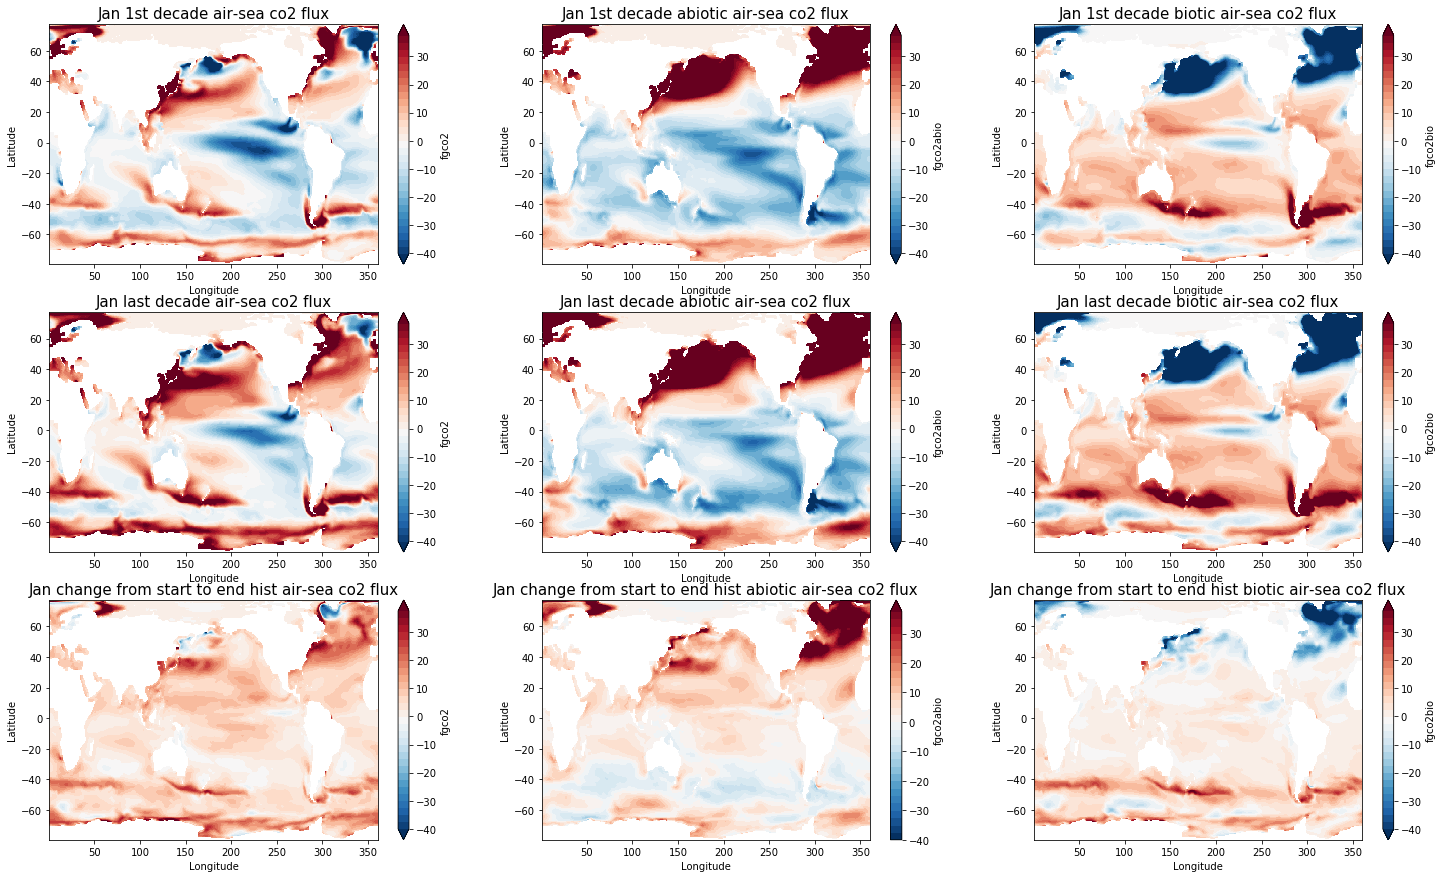

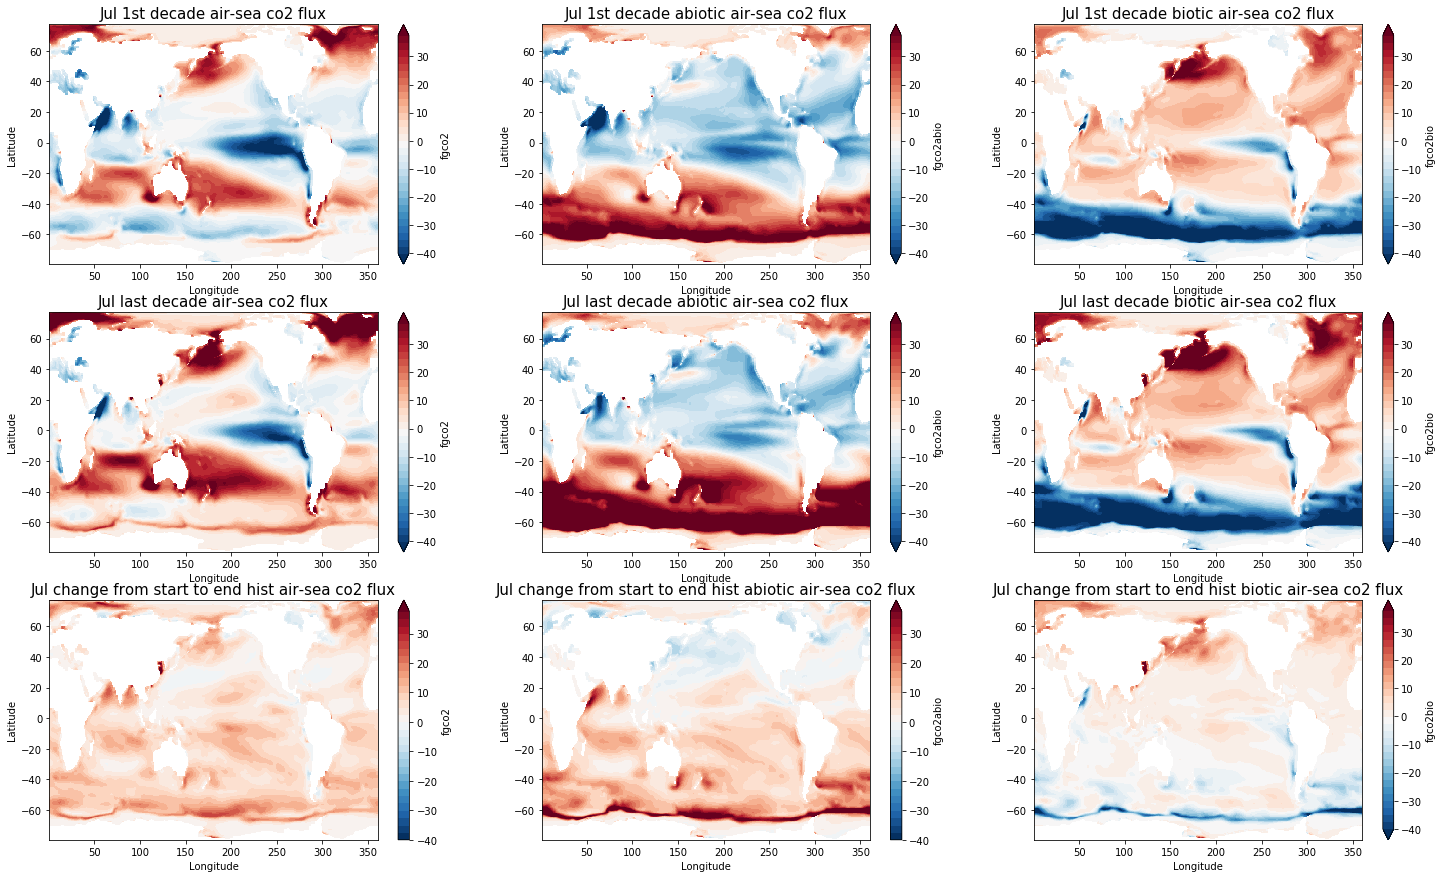

In [34]:
#Set gridding intervals for plotting
levels = np.arange(-40, 40, 2.5)
# Plot for January
fig = plt.figure(figsize=(25, 15))
mapPlotCO2ChangeByMonth(1, 'Jan',levels)

#Plot for July
fig = plt.figure(figsize=(25, 15))
mapPlotCO2ChangeByMonth(7, 'Jul',levels)

Notice that the changes in the abiotic fluxes from the beginning to end of the historical simulation are much larger (increasing) in Jan in the Northern Hemisphere 
and July in the Southern Hemisphere, so that the changes in the flux are larger when the solubility of CO2 is higher. The opposite is the case of biotic fluxes:
the flux becomes more positive in the Northern Hemisphere in July and more positive in the Southern Hemisphere in January.

<a id='southern_ocean'></a>
### Seasonality of CO2 flux and pCO2 in Southern Ocean
Because of the importance of the Southern Ocean for air-sea CO$_2$ fluxes and the variance among models that we observed earlier, we'll focus on the Southern Ocean, and look at how the rate of change of pCO$_2$ (dpCO$_2$/dt) changes over the annual cycle. 

We define the Southern Ocean as latitudes south of 44$^\circ$S and extract grid areas, temperature, and pCO$_2$ for that region

In [22]:
# for this analysis, we need to make sure the models have the same coordinates for surface temperature as for the CO2 flux
# and pCO2
SO_slice_fgco2_ds=dict()
SO_slice_spco2_ds=dict()
SO_slice_tos_ds=dict()
SO_slice_area = dict()
for key in dset_dict_fgco2.keys():
    shptos=dset_dict_tos[key].tos.shape
    shpspco2=dset_dict_spco2[key].spco2.shape
    if shptos==shpspco2: # only include models where temperature and pCO2 are on the same grid
        SO_slice_fgco2_ds[key] = dset_dict_fgco2[key].where(dset_dict_fgco2[key].y<-44,drop=True).compute()
        SO_slice_tos_ds[key] = dset_dict_tos[key].where(dset_dict_tos[key].y<-44,drop=True).compute()
        SO_slice_spco2_ds[key] = dset_dict_spco2[key].where(dset_dict_spco2[key].y<-44,drop=True).compute()
        SO_slice_area[key] = dset_dict_tos[key].areacello
        SO_slice_area[key] = SO_slice_area[key].rename({SO_slice_area[key].dims[1]: 'x',SO_slice_area[key].dims[0]: 'y'})
        SO_slice_area[key] = SO_slice_area[key].assign_coords({'x' : dset_dict_fgco2[key].x.data})
        SO_slice_area[key] = SO_slice_area[key].assign_coords({'y' : dset_dict_fgco2[key].y.data})
        SO_slice_area[key] = SO_slice_area[key].where(SO_slice_area[key].y<-44,drop=True).compute()


First, let's get an idea of the seasonal cycle of the CO$_2$ flux in the Southern Ocean by plotting the average flux in January and July in the historical simulations. We're again using all available models

<Figure size 432x288 with 0 Axes>

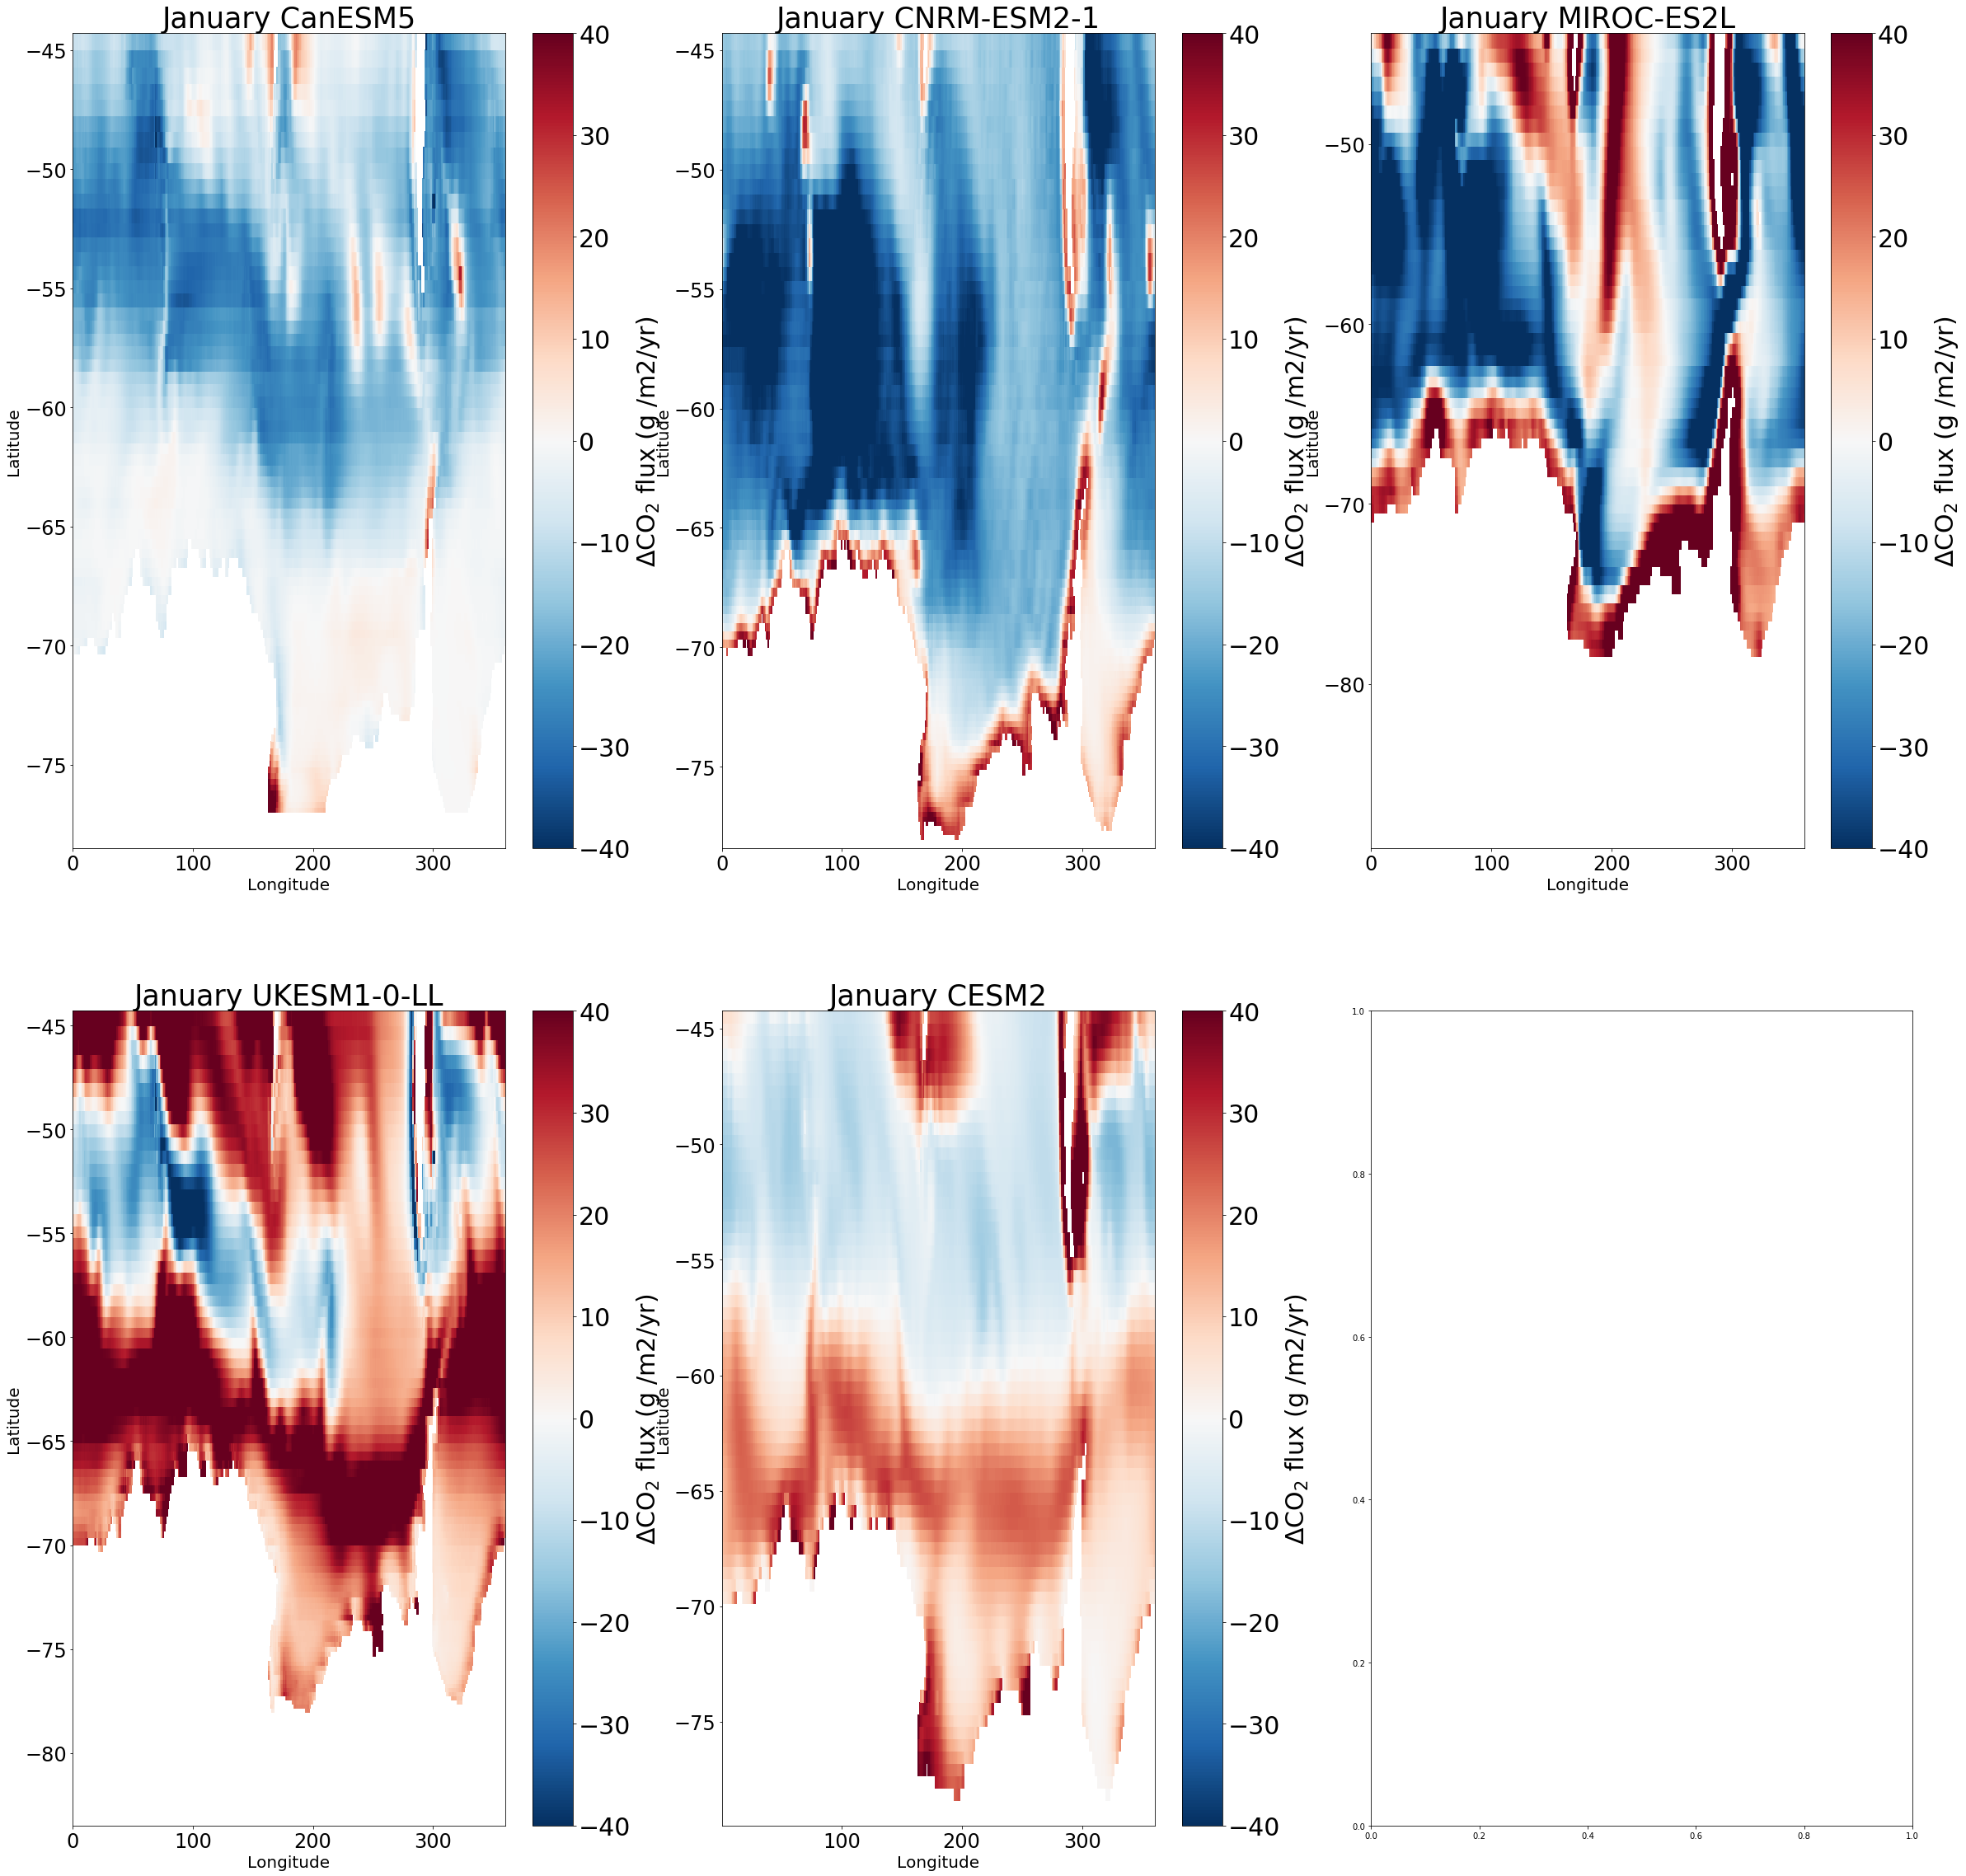

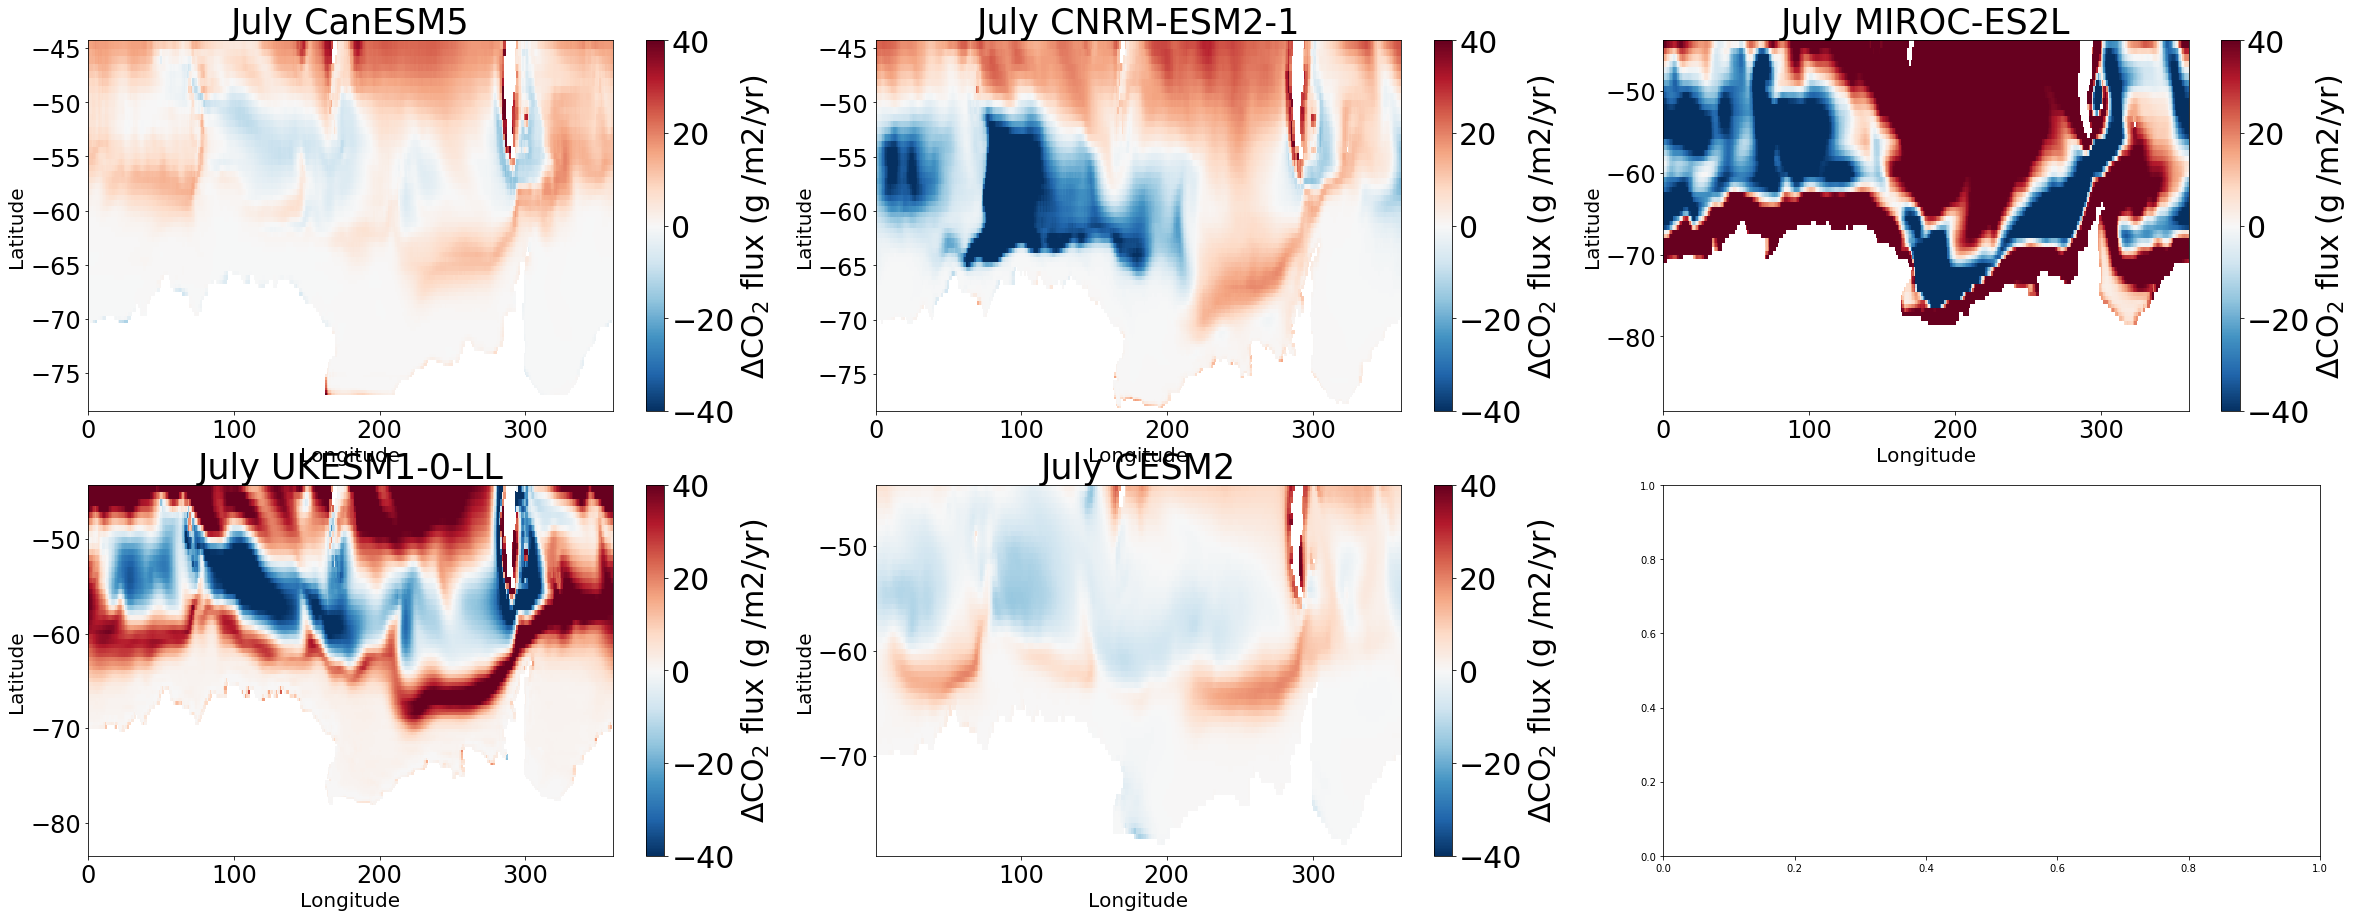

In [35]:
plt.figure()

# January figures
fig, axes = plt.subplots(ncols=3, nrows=2,figsize=(40, 40))
cnt=0
for key in SO_slice_fgco2_ds.keys():
    
    plotdata=SO_slice_fgco2_ds[key].fgco2.groupby('time.month').mean('time')
    axs=axes[np.floor_divide(cnt,3),np.mod(cnt,3)]
    im=plotdata.sel(month=1).plot(ax=axs,robust=True, cmap='RdBu_r',add_colorbar = False, vmin=-40, vmax=40)
    
    # set a colorbar for each subplot
    cbar = fig.colorbar(im,ax=axs)
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('$\Delta$CO$_2$ flux '+'(g /m2/yr)',fontsize=30)
    
    # title is just model name
    axs.set_title('January '+modelnames[key],fontsize=35)
    axs.set_xlabel('Longitude',fontsize=20)
    axs.set_ylabel('Latitude',fontsize=20)
    axs.tick_params(axis = 'both', which = 'major', labelsize = 24)
    axs.tick_params(axis = 'both', which = 'minor', labelsize = 16)
    cnt=cnt+1
    
    # July figures
fig, axes = plt.subplots(ncols=3, nrows=2,figsize=(40, 15))
cnt=0
for key in SO_slice_fgco2_ds.keys():
    
    plotdata=SO_slice_fgco2_ds[key].fgco2.groupby('time.month').mean('time')
    axs=axes[np.floor_divide(cnt,3),np.mod(cnt,3)]
    im=plotdata.sel(month=7).plot(ax=axs,robust=True, cmap='RdBu_r',add_colorbar = False, vmin=-40, vmax=40)
    
    # set a colorbar for each subplot
    cbar = fig.colorbar(im,ax=axs)
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label('$\Delta$CO$_2$ flux '+'(g /m2/yr)',fontsize=30)
    
    # title is just model name
    axs.set_title('July '+modelnames[key],fontsize=35)
    axs.set_xlabel('Longitude',fontsize=20)
    axs.set_ylabel('Latitude',fontsize=20)
    axs.tick_params(axis = 'both', which = 'major', labelsize = 24)
    axs.tick_params(axis = 'both', which = 'minor', labelsize = 16)
    cnt=cnt+1
plt.subplots_adjust(hspace=0.5, wspace=0.5)

Now, let's compute the seasonal cycle of the area-weighted average of the CO2 flux south of 44$^\circ$S during the last 10 yrs of the historical period

In [24]:
def F_sc_fco2(var_ds,units_cv,area):
    """ Extract the last 10 years of the simulation and double the time series to 24 months 
    by repeating the next 12 months, and rotate the axis to start the year in Dec and compute the seasonal cycle"""
    var_SO_mon = var_ds.fgco2[-120:,:,:].groupby('time.month').mean('time')*units_cv  
    var_SO_mon_sc = xr.concat([var_SO_mon]*2, 'month')
    var_SO_mon_sc['month'] = np.arange(24) + 2
    var_SO_mon_scd = var_SO_mon_sc.roll(month =1)
    
    var_SO_mon_SC = ((var_SO_mon_scd*area.data).sum(dim=['x','y'])/area.sum(dim=['x','y']))
    
    return var_SO_mon_SC[1:]



fgco2_SO_sc = dict()
for key in SO_slice_fgco2_ds.keys():
    fgco2_SO_sc[key] = F_sc_fco2(SO_slice_fgco2_ds[key],1,SO_slice_area[key].areacello)




In order to understand the differences in the carbon cycle between models, we compute the rate of change in pCO2 over each month of the year, and the temperature and DIC driven components of that change.

In [25]:
units_spco2 = 0.00000986923266716*1e6

def F_sst_pCO2_comp(spco2_ds,sst_ds,units_cv,area):
    """ computes the temperature component of surface pCO2 """
    
    spco2_SO_mon_a = spco2_ds.spco2[-120:,:,:].groupby('time.month').mean('time')*units_cv
    spco2_SO_clm = spco2_SO_mon_a.mean('month')
    
    sst_SO_mon_a = sst_ds.tos[-120:,:,:].groupby('time.month').mean('time')
    sst_SO_mon = xr.concat([sst_SO_mon_a]*2, 'month')
    sst_SO_mon['month'] = np.arange(24) + 2
    sst_SO_mon_r = sst_SO_mon.roll(month =1)[:]
    
    spco2_SO_mon = xr.concat([spco2_SO_mon_a]*2, 'month')
    spco2_SO_mon['month'] = np.arange(24) + 2
    spco2_SO_mon_r = spco2_SO_mon.roll(month =1)[:]
    
    sst_SO_mon_dt = sst_SO_mon_r.diff('month')                                            
    pco2_SO_mon_dt = spco2_SO_mon_r.diff('month')
    dpCO2_sst_comp = spco2_SO_clm.data*0.0423*sst_SO_mon_dt
    
    dpCO2_dic_comp = pco2_SO_mon_dt.data - dpCO2_sst_comp

    
    dpCO2_sst_comp_sc = (((dpCO2_sst_comp*area.data).sum(dim=['x','y']))/area.sum(dim=['x','y']))
    dpCO2_DIC_comp_sc = (((dpCO2_dic_comp*area.data).sum(dim=['x','y']))/area.sum(dim=['x','y']))
    dpCO2_SO_mon_dt_SC = ((pco2_SO_mon_dt*area.data).sum(dim=['x','y'])/area.sum(dim=['x','y']))

    return dpCO2_sst_comp_sc[:],dpCO2_DIC_comp_sc[:],dpCO2_SO_mon_dt_SC[:]

sst_pco2_comp = dict()
DIC_pco2_comp = dict()
dpCO2_dt = dict()

for key in SO_slice_spco2_ds.keys():
    sst_pco2_comp[key],DIC_pco2_comp[key],dpCO2_dt[key]= F_sst_pCO2_comp(SO_slice_spco2_ds[key],SO_slice_tos_ds[key],units_spco2,SO_slice_area[key].areacello)


Populating the interactive namespace from numpy and matplotlib


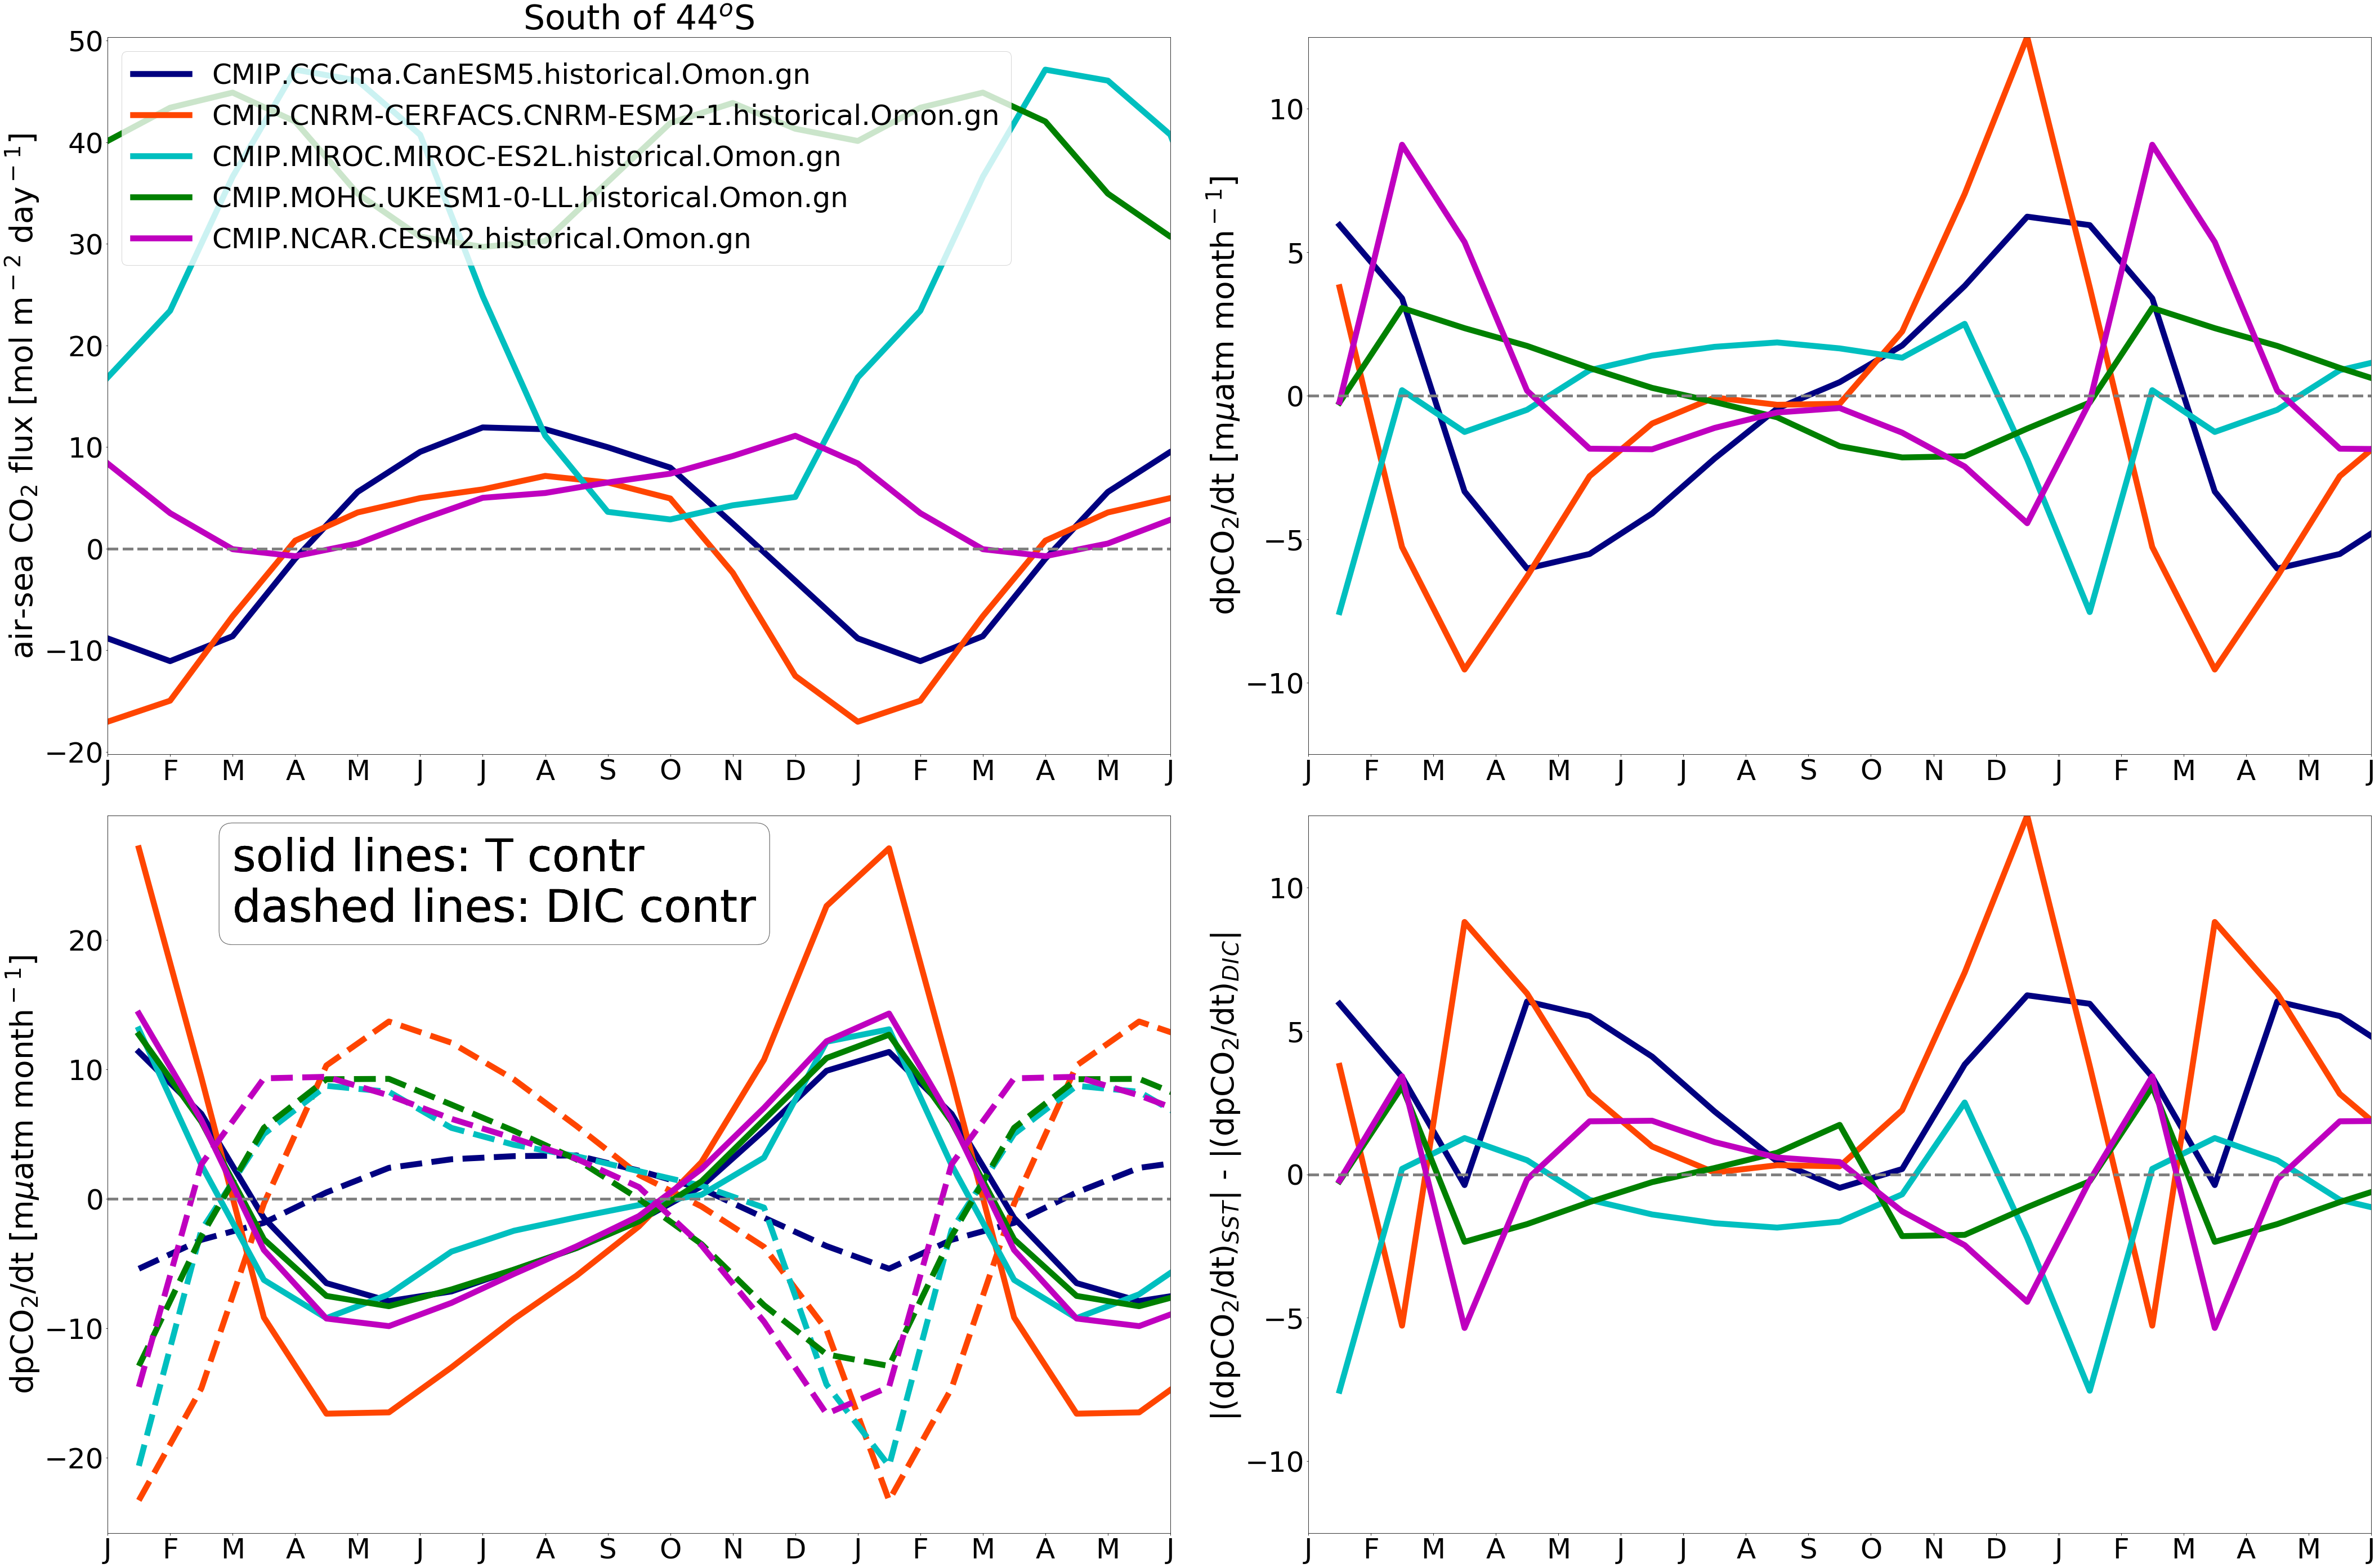

In [26]:
import pylab as plt
import mpl_toolkits as basemap
%matplotlib inline
%pylab inline
title_font = {'fontname':'Calibri (Body) ', 'size':'80', 'color':'black', 'weight':'normal','verticalalignment':'bottom'}
my_xticks = ['J','F','M','A', 'M','J','J','A','S','O','N','D','J','F','M','A', 'M','J','J','A','S','O','N','D']
my_xticks_b = ['J','F','M','A', 'M','J','J','A','S','O','N','D','J','F','M','A', 'M','J','J','A','S','O','N','D']
plt.figure(figsize=[60,40])
plt.rcParams['font.size'] = 50
plt.rcParams['lines.linewidth'] = 10.5
plt.rcParams['savefig.dpi'] = 200
units_cccma = 12.01/44.01
time = range(23)
time_dt = np.arange(0.5,23,1)
ylfz= 55

lz = 5

time = range(23)

# colors for each model

clrs = ['navy','orangered','c','g','m','k','maroon','coral']

#########################
# CO2 air-sea flux plots
#########################

subplot(2,2,1)
for n,key in enumerate(SO_slice_spco2_ds.keys()):
    plot(time,fgco2_SO_sc[key],color = clrs[n],label = key)
    plt.xticks(time, my_xticks)
    plot(time,np.transpose(np.zeros(len(time))),'--',linewidth = lz,color = 'grey')
    plt.title('South of 44$^o$S')
    plt.xlim(0,17)
    plt.legend(loc = 'best')
    plt.ylabel('air-sea CO$_2$ flux [mol m$^-$$^2$ day$^-$$^1$]' ,fontsize = ylfz)



#########################
# dpCO2/dt plots
#########################
subplot(2,2,2)
for n,key in enumerate(SO_slice_spco2_ds.keys()):
    plot(time_dt,dpCO2_dt[key],color = clrs[n],label = key)
    plt.xticks(time, my_xticks_b)
    plot(time,np.transpose(np.zeros(len(time))),'--',linewidth = lz,color = 'grey')
    plt.ylim(-10,12)
    plt.xlim(0,17)
    plt.ylim(-12.5,12.5)
    plt.ylabel('dpCO$_2$/dt [m$\mu$atm month$^-$$^1$]' ,fontsize = ylfz)

    
#######################################################
# dpCO2/dt divided by T and DIC contributions plots
######################################################
subplot(2,2,3)
for n,key in enumerate(SO_slice_spco2_ds.keys()):
    plot(time_dt,sst_pco2_comp[key],color = clrs[n],label = key)
    plot(time_dt,DIC_pco2_comp[key],'--',color = clrs[n],label = key)
    plt.xticks(time, my_xticks_b)
    plot(time,np.transpose(np.zeros(len(time))),'--',linewidth = lz,color = 'grey')
    textstr = '\n'.join((
    'solid lines: T contr',
    'dashed lines: DIC contr'))
    plt.xlim(0,17)
    plt.ylabel('dpCO$_2$/dt [m$\mu$atm month$^-$$^1$]' ,fontsize = ylfz)
    props = dict(boxstyle='round', facecolor='white', alpha=0.2)
    plt.text(2, 28, textstr, fontsize=80,
        verticalalignment='top', bbox=props)

    
############################################################
# Magnitude of T contribution - magnitude of DIC contribution
###########################################################
subplot(2,2,4)
for n,key in enumerate(SO_slice_spco2_ds.keys()):
    plot(time_dt,abs(sst_pco2_comp[key]) - abs(DIC_pco2_comp[key]),color = clrs[n],label = key)
    plt.xticks(time, my_xticks_b)
    plot(time,np.transpose(np.zeros(len(time))),'--',linewidth = lz,color = 'grey')
    plt.xlim(0,17)
    plt.ylim(-12.5,12.5)
    plt.ylabel('|(dpCO$_2$/dt)$_S$$_S$$_T$| - |(dpCO$_2$/dt)$_D$$_I$$_C$| ' ,fontsize = ylfz)

plt.tight_layout()

Temperature and DIC are the dominant contributors to pCO$_2$ anomalies, however they do not explain all of the variability of pCO$_2$ (compare the two right panels), indicating that the alkalinity and freshwater components may play a role. Both display a pronounced seasonality and are largely opposing in their sign.

## Comparing the Oxygen Minumum Zones (OMZs) in in the global ocean between CMIP6 models

Most models produce areas of low oxygen in the eastern Pacific and Atlantic, as well as the northern Indian Ocean. The maps at different depths however, indicate that the lateral extend of the OMZs varies substantially between models when compared to World Ocean Atlas observations. E.g. at 500m none of the models shows the westward expansion of the OMZ in the tropical Pacific. At larger depths, difference get even more pronounced (see also in the vertical sections further below). While the representation of the OMZ in the tropical Pacific varies, most of all models show categorically too low concentrations in the tropical Atlantic, where the observations do not support a North-South 'connection' of the OMZ. To see maps at different depths or depth sections at different longitude modify the variables `o2_map_depths` and `o2_section_lon` accordingly.

In [27]:
# depths for map plots
o2_map_depths = [500]
o2_section_lon = [240]

# reset the plotting style to default
plt.style.use('default')

# average global oxygen fields
def map_ave(ds):
    ds =  ds.copy()
    chunkdict={}
    if 'member_id' in ds.dims:
        chunkdict['member_id'] = 1
    
    experiment_id  = ds.attrs['experiment_id']
    
    # preserve attributes from dataset
    attrs = ds.attrs.copy()
    attrs['averaged_members'] = len(ds.member_id)
    
    if 'member_id' in ds.dims:
#         ds =  ds.mean('member_id')
        #low cost version
        ds = ds.isel(member_id=0)
        
    # average the last 10 years of each run
    time_idx = [-10*12, -1]
    attrs['averaged_years'] = [ds.time.data[time_idx[0]], ds.time.data[time_idx[1]]]
    ds = ds.isel(time=slice(time_idx[0],time_idx[1])).mean('time')
    ds.attrs = attrs
    return ds

dset_dict_o2_ave = {k: map_ave(ds) for k, ds in dset_dict_o2.items()}

# add world ocean atlas data to the dictionary. This is a longterm time average.
woa_path = 'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/oxygen/all/1.00/woa18_all_o00_01.nc'
obs = xr.open_dataset(woa_path, decode_times=False)
obs_o2 = obs[['o_an']].squeeze(drop=True).rename({'lon':'x', 'lat':'y', 'depth':'lev', 'o_an':'o2'})
obs_o2 = correct_lon(broadcast_lonlat(obs_o2))
obs_o2.attrs['source_id'] = 'World Ocean Atlas'
obs_o2.attrs['grid_label'] = ''
obs_o2.attrs['experiment_id'] = 'observations'
obs_o2['o2'].attrs['standard_name'] = 'o2'
obs_o2['o2'].attrs['long_name'] = 'o2'
obs_o2.attrs['averaged_members'] = 1
obs_o2
dset_dict_o2_ave['obs_woa'] = obs_o2

# exclude because of isopycnal levels
del dset_dict_o2_ave['CMIP.NCC.NorESM1-F.piControl.Omon.gn']

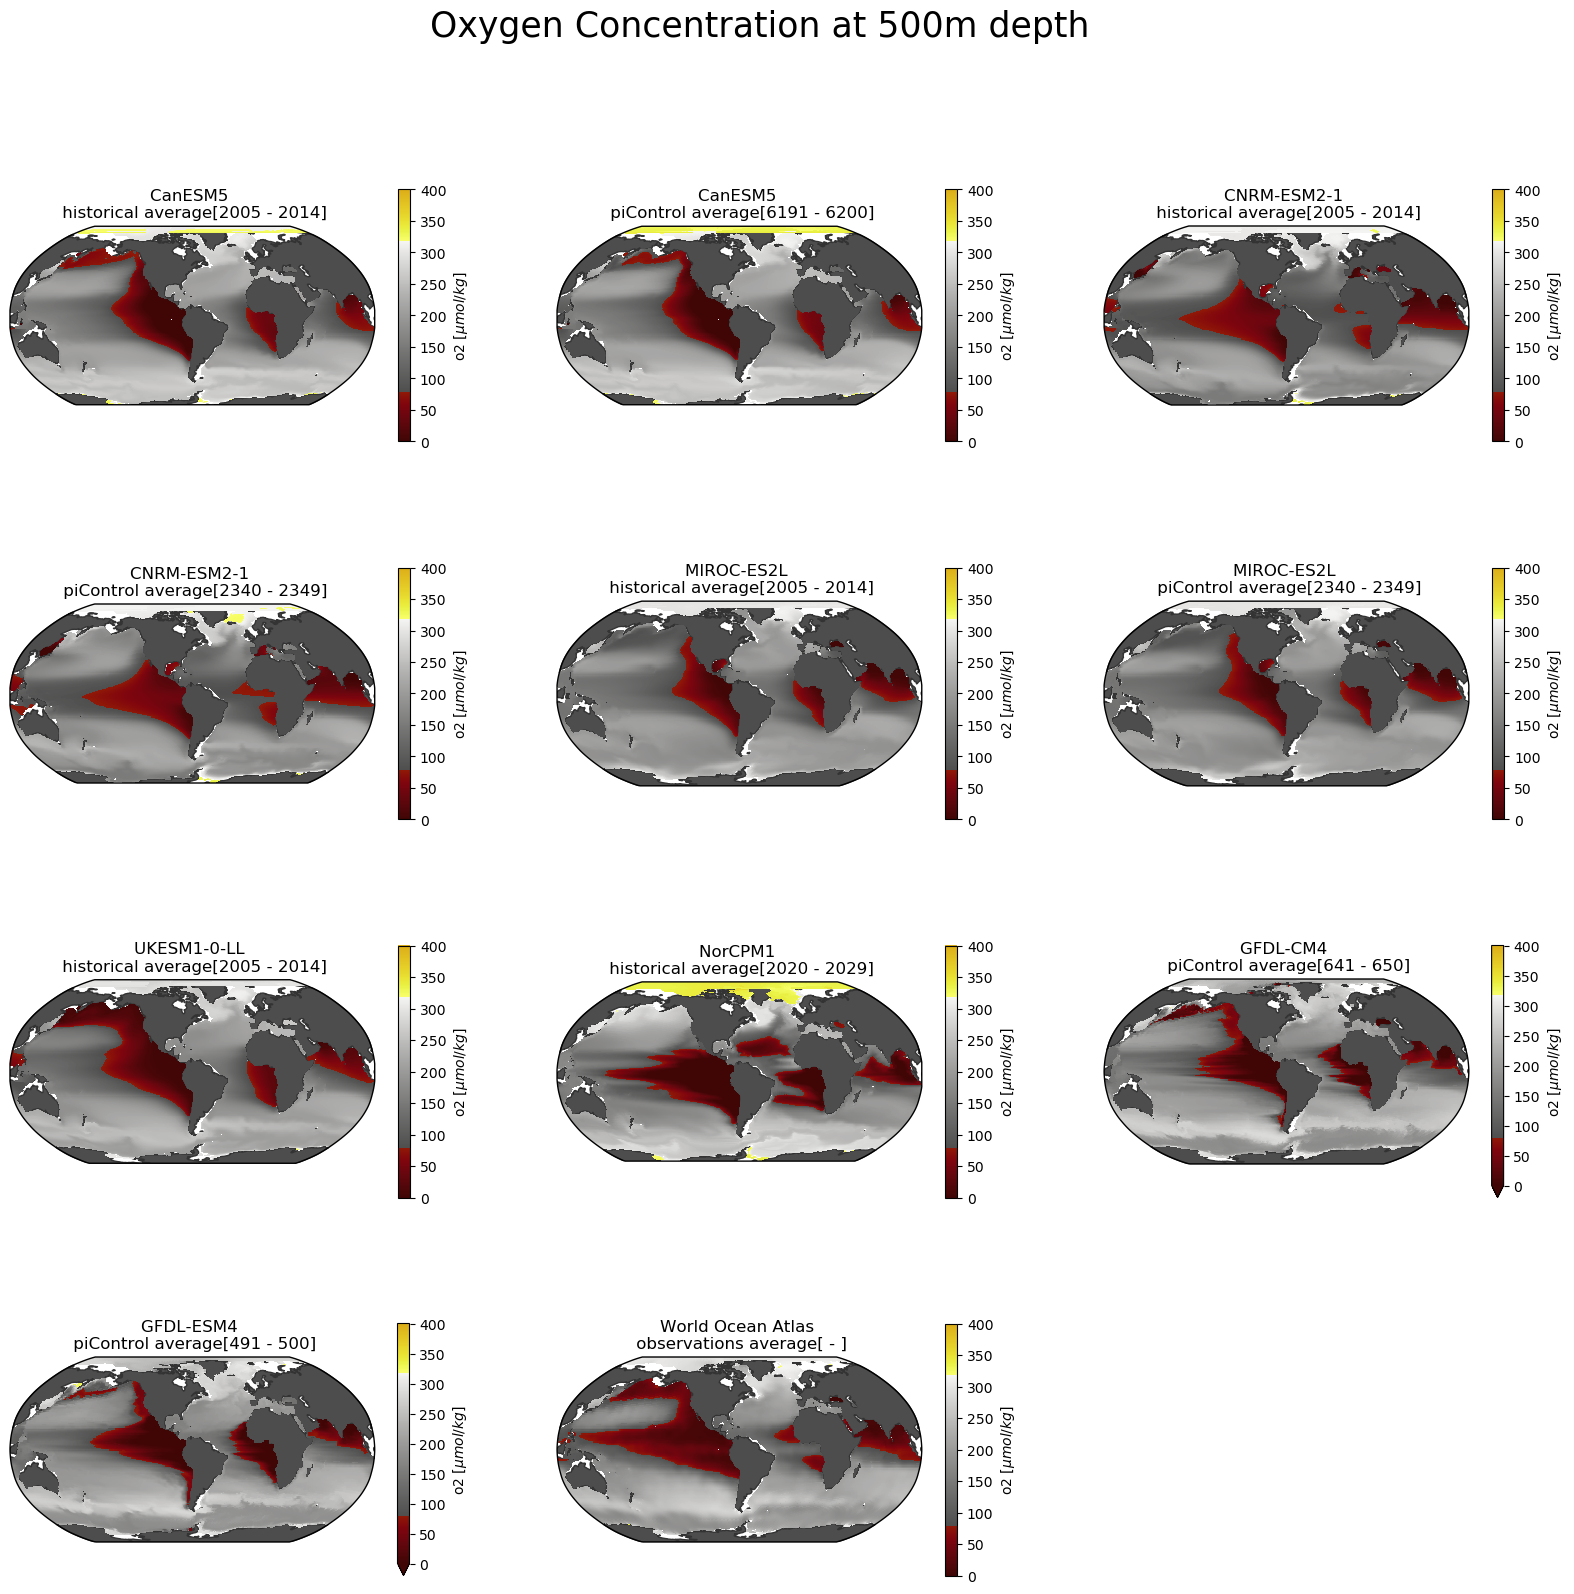

In [28]:
center = -70 # longitude center of the map projection
for z in o2_map_depths: 
    fig, axarr = plt.subplots(ncols=3, nrows=4,
                              figsize=[20,18],
                              subplot_kw={'projection':ccrs.Robinson(center)})
    for ax, (mod, ds) in zip(axarr.flat, dset_dict_o2_ave.items()): 
        # interpret level
        pds = ds.o2.interp(lev=z).load()
        
        # convert to mymol/kg
        if mod != 'obs_woa': # the units for woa are already ok
            rho_ref = 1035
            pds = pds * 1e6 / rho_ref
        pds.attrs['units'] = '$\mu mol/kg$'
        
        # fix lons for the projection (still some issues with the Arctic)
        lons = pds.lon.data
        lons[lons > 180+center] += -360
        pds.lon.data = lons
        
        xs = pds.x.data
        xs[xs > 180+center] += -360
        pds.x.data = xs
        
        pds = pds.sortby('x')
        if not 'averaged_years' in ds.attrs.keys():
            startyear = ''
            endyear = ''
        else:
            if isinstance(ds.attrs['averaged_years'][0], np.datetime64):
                startyear = pd.to_datetime(ds.attrs['averaged_years'][0]).year
                endyear = pd.to_datetime(ds.attrs['averaged_years'][1]).year
            else:
                startyear = ds.attrs['averaged_years'][0].year
                endyear = ds.attrs['averaged_years'][1].year
        
        # actually plot
        pds.plot(ax=ax, vmax=400, vmin=0,
                 x='lon', y='lat', cmap=cmo.oxy,
                 transform=ccrs.PlateCarree())
        ax.set_title('%s \n %s average[%s - %s]' %(ds.attrs['source_id'],
                                            ds.attrs['experiment_id'],
                                            startyear,
                                            endyear,
                                           ))
        ax.add_feature(cfeature.LAND, facecolor='0.3', edgecolor='0.2')
    for ax in axarr.flat[-1:]:
        ax.set_visible(False)
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Oxygen Concentration at %im depth' %z, fontsize=25)
    plt.show()

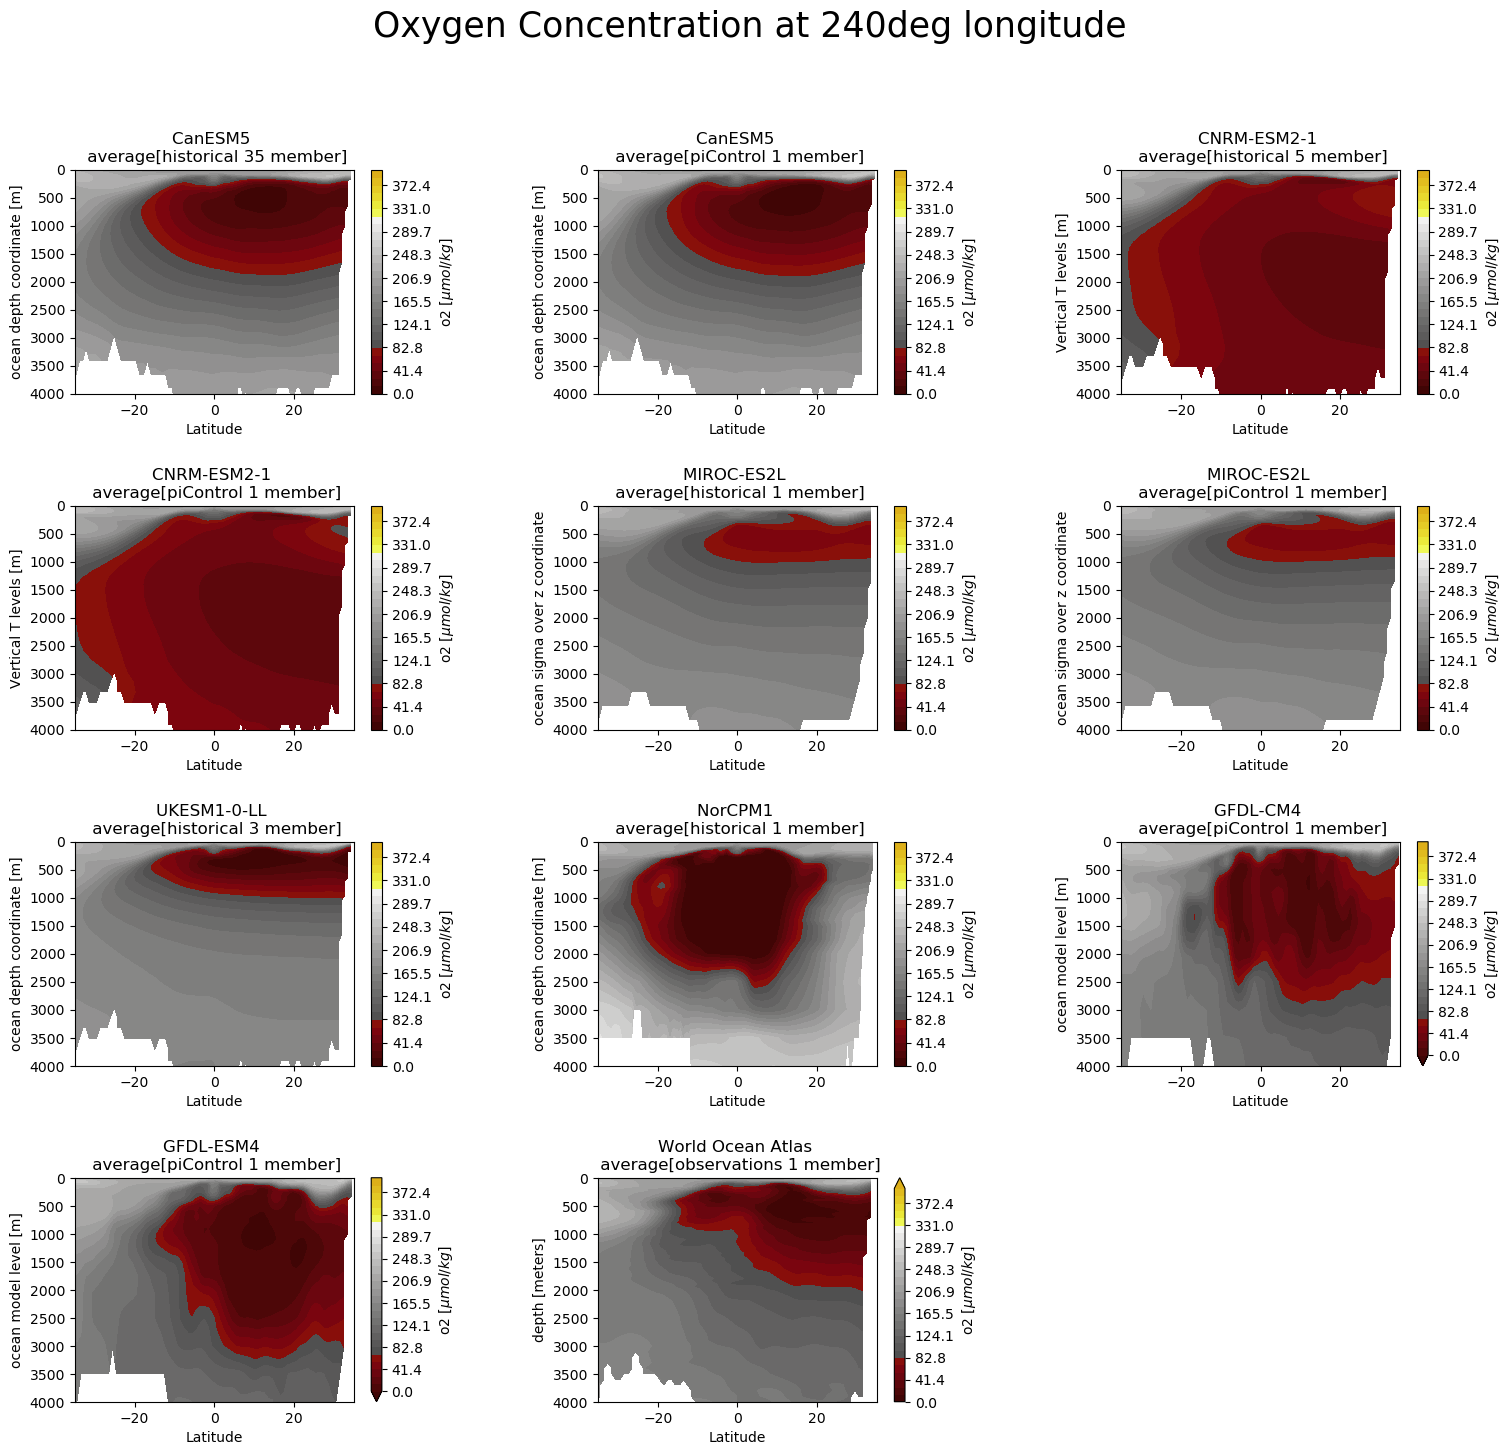

In [30]:
for lon in o2_section_lon: 
    fig, axarr = plt.subplots(ncols=3, nrows=4, figsize=[18,16])
    for ax, (mod, ds) in zip(axarr.flat, dset_dict_o2_ave.items()): 
        # Fix for duplicate lons (some models have that....)
        # https://stackoverflow.com/a/51077784
        _, index = np.unique(ds.x, return_index=True)
        ds = ds.isel(x=index)
        
        # interpret level
        pds = ds.o2.interp(x=lon).load()
        
        # convert to mymol/kg
        if mod != 'obs_woa': # the units for woa are already ok
            rho_ref = 1035
            pds = pds * 1e6 / rho_ref
        pds.attrs['units'] = '$\mu mol/kg$'
        
        # actually plot
        pds.plot.contourf(levels=30, ax=ax, vmax=400, vmin=0, yincrease=False,
                 x='lat', y='lev', cmap=cmo.oxy)
        ax.set_title('%s \n average[%s %i member]' %(ds.attrs['source_id'],
                                                          ds.attrs['experiment_id'],
                                                          ds.attrs['averaged_members']))
        ax.set_xlim(-35,35)
        ax.set_ylim(4000,0)
        ax.set_xlabel('Latitude')
        
    for ax in axarr.flat[-1:]:
        ax.set_visible(False)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    fig.suptitle('Oxygen Concentration at %ideg longitude' %lon, fontsize=25)